# Importing and installing libraries

## Cudf installation

In [1]:
# pyarrow update (necessary to avoid an error that arises when importing cudf)

! pip install pyarrow --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [2]:
# Cudf installation

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 438 (delta 121), reused 57 (delta 54), pack-reused 269
Receiving objects: 100% (438/438), 118.31 KiB | 7.89 MiB/s, done.
Resolving deltas: 100% (223/223), done.
***********************************************************************
We will now install RAPIDS via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

working_on = 'Jupyter'
if working_on == 'Colab':
    import cudf
    %load_ext cudf.pandas


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from scipy import stats
from scipy.stats.mstats import winsorize

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

In [2]:
if working_on == 'Jupyter':

    path_tesi_folder = 'C:/Users/federico/Desktop/Magistrale DSBA/Tesi/Dati'
    # path_v0 = path_tesi_folder + '/Dati finali 2022/v0'
    path_v1 = path_tesi_folder + '/Dati finali 2022/v1'
    path_v2 = path_tesi_folder + '/Dati finali 2022/v2'
    path_v3 = path_tesi_folder + '/Dati finali 2022/v3'

elif working_on == 'Colab':

    from google.colab import drive
    drive.mount('/content/drive')

    path_tesi_folder = '/content/drive/MyDrive/Tesi/Dati'
    # path_v0 = path_tesi_folder + '/Dati finali 2022/v0'
    path_v1 = path_tesi_folder + '/Dati finali 2022/v1'
    path_v2 = path_tesi_folder + '/Dati finali 2022/v2'
    path_v3 = path_tesi_folder + '/Dati finali 2022/v3'

else:
    raise Exception('Ops! Something wrong!')

# Useful functions

In [3]:
'''
set_types_columns: function that sets the right datatypes (either float64 or string) to the columns of the dataframe
'''
string_columns = ['Ragione sociale', 'Codice fiscale', 'Indirizzo sede legale - Regione', 'Stato giuridico',
                  'Categoria societaria', 'ATECO 2007\ncodice', 'ATECO 2007\ndescrizione', 'Attività principale']

def set_types_columns(df, string_columns):

    for col in df.columns:
        if col in string_columns:
            df[col] = df[col].astype('string')
        else:
            df[col] = df[col].astype('float64')

    return df

'''
remove_Unnamed_columns: function that removes the 'Unnamed' like columns at the beginning of the dataframe
'''
def remove_Unnamed_columns(df):

    cols_to_delete = [col for col in df.columns if col.startswith('Unnamed')]

    if len(cols_to_delete) != 0:
        df.drop(df.loc[:,cols_to_delete], axis=1, inplace=True)

    return df

In [4]:
'''
dictionary_missing_values: A function that takes in input a pandas dataframe and an axis and return a dictionary with the percentage
of missing values by the specified axis
Input:
- df: input dataframe
- axis along which control for missing values
Output:
- percentage_null_dict: dictionary of the form index:percentage of missings by axis
Other variables:
- length: length of the axis (for percentage calculation)
'''


def dictionary_missing_values(df, axis, percentage_or_number='Percentage'):

    if axis == 0:
        length = len(df)

    elif axis == 1:
        length = len(df.columns)

    else:
        raise Exception('Specified wrong axis!')

    percentage_null_dict = df.isnull().sum(axis=axis).sort_values(ascending=False).to_dict()

    if percentage_or_number == 'Percentage':

        return {key: value/length for key, value in percentage_null_dict.items()}

    elif percentage_or_number == 'Number':

        return percentage_null_dict

    else:

        raise Exception('Invalid parameter inserted!')


'''
filtered_df_per_missing_values: A function that takes in input a pandas dataframe and a threshold representing the maximum percentage
of missing values (by specified axis) and returns the filtered dataframe

Input:
- df: input dataframe
- axis along which control for missing values
- threshold for maximum percentage of missing per row
Output:
- filtered_df: new dataframe filtered based on the input dataframe and the threshold specified
Other variables:
- percentage_null_col_df: dictionary of the form index:percentage of missings by row (from the function dictionary_missing)
- filtered_dict: same dictionary keeping only the key-value pairs with value<threshold
- filtered_indexes: the keys of the dictionary filtered_dict, corresponding to the indexes of the original dataframe satisfying
the condition of the maximum percentage of missing values
'''

def filtered_df_per_missing_values(df, axis, threshold_missings):

    percentage_null_df = dictionary_missing_values(df, axis)

    filtered_dict = {key: value for key, value in percentage_null_df.items() if value < threshold_missings}
    filtered_indexes = list(filtered_dict.keys())

    if axis == 1:
        filtered_df = df[df.index.isin(filtered_indexes)].reset_index(drop=True)

    elif axis == 0:
        filtered_df = df[filtered_indexes].reset_index(drop=True)

    return filtered_df

'''
missing_values_interpolation: function performing missing values interpolation on the numerical columns of the dataframe
'''

def missing_values_interpolation(df, method_missings_interpolation):

    df_numerical = df.select_dtypes(include=['float64'])

    if method_missings_interpolation == None:

        return df

    for col in df_numerical.columns:
        df[col].interpolate(method=method_missings_interpolation, inplace=True)

    return df

'''
outliers_identification: function handling the outliers of the dataframe through the specified method
'''

def outliers_identification(df, method_outliers_identification, threshold_outliers):

    df_numerical = df.select_dtypes(include=['float64'])

    # method_outliers_identification == None we want all the columns to be transformed
    if method_outliers_identification == None:

        return {col: True for col in df_numerical.columns}

    elif method_outliers_identification == 'z_score':

        # Calculate Z-scores for each column
        z_scores = stats.zscore(df_numerical)

        # Identify columns with outliers
        columns_outliers_dict = (abs(z_scores) > threshold_outliers).any(axis=0).to_dict()

    elif method_outliers_identification == 'interquantile_range':

        # Calculate the IQR for each column
        Q1 = df_numerical.quantile(0.25)
        Q3 = df_numerical.quantile(0.75)
        IQR = Q3 - Q1

        # Identify columns with outliers
        columns_outliers_dict = ((df_numerical < (Q1 - threshold_outliers * IQR)) | (df_numerical > (Q3 + threshold_outliers * IQR))).any().to_dict()

    else:

        raise Exception('Specified invalid outliers identification method')

    return columns_outliers_dict

'''
outliers_transformation: function transforming the outliers according to the specified method
'''
def outliers_transformation(df, method_outliers_transformation, method_outliers_identification, threshold_outliers):

    if method_outliers_transformation == None:

        return df

    df_numerical = df.select_dtypes(include=['float64'])

    for col in df_numerical.columns:

        if outliers_identification(df=df, method_outliers_identification=method_outliers_identification, threshold_outliers=threshold_outliers)[col] == True:

            if method_outliers_transformation == 'log':

                df[col] = np.log1p(df[col])


            elif method_outliers_transformation == 'winsorization':

#                 # Handle masked values before winsorization
#                 non_masked_values = np.ma.masked_invalid(df[col])
#                 winsorized_values = winsorize(non_masked_values.compressed(), limits=[0.01, 0.01])

#                 # Ensure the length matches before assigning
#                 df[col] = np.nan  # Fill the column with NaN
#                 df.loc[non_masked_values.mask == False, col] = winsorized_values

                df[col] = winsorize(df[col], limits=[0.01, 0.01], nan_policy='omit')

            else:

                raise Exception('Specified invalid outliers transformation method')


    return df


'''
preprocessing_df: function that takes in input a dataframe and returns the preprocessed dataframe
'''
def preprocessing_df(X, y, threshold_col=0.9, threshold_row=0.5, method_missings_interpolation=None,
                     method_outliers_identification=None, threshold_outliers=3,
                     method_outliers_transformation=None):

    # Combine X and y to ensure consistent transformations
    df = pd.concat([X, y], axis=1)

    # Filtering the dataframe per missing by column
    df = filtered_df_per_missing_values(df, axis=0, threshold_missings=threshold_col)

    # Splitting X and y back
    X = df.drop(columns=['Default'])
    y = df['Default']

    # Filtering the dataframe per missing by row
    df = filtered_df_per_missing_values(df, axis=1, threshold_missings=threshold_row)

    # Outliers transformation
    df = outliers_transformation(df, method_outliers_transformation=method_outliers_transformation,
                                 method_outliers_identification=method_outliers_identification,
                                 threshold_outliers=threshold_outliers)

    # Missing values interpolation
    df = missing_values_interpolation(df, method_missings_interpolation=method_missings_interpolation)

    # Splitting X and y back
    X = df.drop(columns=['Default'])
    y = df['Default']

    return remove_Unnamed_columns(X), y

# Company data

In [ ]:
path_SMEs_folder = path_tesi_folder + '/SMEs_downloads'
path_LargeCompanies_folder = path_tesi_folder + '/LargeCompanies_downloads'
SMEs_files = os.listdir(path_SMEs_folder)
LargeCompanies_files = os.listdir(path_LargeCompanies_folder)

In [ ]:
# SMEs_all_years = pd.read_excel(io=path_SMEs_folder+'/SME001.xlsx', sheet_name='Risultati')

# for i in tqdm(range(1, len(SMEs_files))):
#     new_file = pd.read_excel(io=path_SMEs_folder+'/'+SMEs_files[i], sheet_name='Risultati')
#     SMEs_all_years = pd.concat([SMEs_all_years, new_file])

SMEs_all_years

100%|██████████████████████████████████████████████████████████████████████████████| 343/343 [3:49:45<00:00, 40.19s/it]


,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Ricavi delle vendite (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Utile netto (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Totale attività (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Capitalizzazione corrente\nmigl EUR\n(Rate at last closing date),...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,ATECO 2007\ncodice,ATECO 2007\ndescrizione,Attività principale,Società artigiana,Start-up innovativa,PMI innovativa,Operatore estero
0,1.0,MONZA TRADING S.R.L. IN LIQUIDAZIONE,4701300966,Lombardia,Cessata,Società di capitale,785405170,22085,16439016,n.d.,...,n.d.,n.d.,-7435,464310.0,"Commercio all'ingrosso di elettrodomestici, di...",Wholesale,no,no,no,no
1,2.0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,470013870,2899995,19725877,n.d.,...,1072802,2434155,6147720,920009.0,Altre attività connesse con le lotterie e le s...,Services,no,no,no,no
2,3.0,ORO ITALIA INVESTIMENTI S.R.L. IN LIQUIDAZIONE,10879461001,Lazio,In liquidazione,Società di capitale,397428887,13692,693491,n.d.,...,12298,34975,116345,467220.0,Commercio all'ingrosso di metalli non ferrosi ...,Wholesale,no,no,no,no
3,4.0,FRI-EL TRADING S.R.L.,2893370219,Trentino-Alto Adige,Attiva,Società di capitale,379012787,640571,36118357,n.d.,...,-2301,50831,66803,351400.0,Commercio di energia elettrica,Services,no,no,no,no
4,5.0,DR ITALIA S.R.L.,990010944,Molise,Attiva,Società di capitale,373565370,2604803,18435879,n.d.,...,n.d.,n.d.,14980,451101.0,Commercio all'ingrosso e al dettaglio di autov...,NaN,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,2259.0,EDRIS S.R.L. - IN LIQUIDAZIONE,1990040840,Sicilia,Cessata,Società di capitale,n.d.,n.d.,573000,n.d.,...,-63694,-195908,-47617,106120.0,Molitura di altri cereali,NaN,no,no,no,no
2259,2260.0,CONSORZIO FIDI COMMERCIO DI AG. CONS. FIDI PER...,90004180841,Sicilia,Cessata (In liquidazione),Società di capitale,n.d.,n.d.,0,n.d.,...,0,0,0,661950.0,Servizi di trasferimento di denaro (money tran...,NaN,no,no,no,no
2260,2261.0,PRO SALUS SOC.COOP.A R.L.,1817070848,Sicilia,In liquidazione,Società di capitale,n.d.,n.d.,6000,n.d.,...,679,679,679,869000.0,Altri servizi di assistenza sanitaria,NaN,no,no,no,no
2261,2262.0,ASPASIA SOC. COOP.,1789850847,Sicilia,Attiva,Società di capitale,n.d.,n.d.,6000,n.d.,...,-157,0,0,411000.0,Sviluppo di progetti immobiliari senza costruz...,NaN,no,no,no,no


In [ ]:
# SMEs_all_years.to_csv('C:/Users/federico/Desktop/SMEs_all_years.csv', sep=',')

In [ ]:
# LargeCompanies_all_years = pd.read_excel(io=path_LargeCompanies_folder+'/BIG001.xlsx', sheet_name='Risultati')

# for i in tqdm(range(1, len(LargeCompanies_files))):
#     new_file = pd.read_excel(io=path_LargeCompanies_folder+'/'+LargeCompanies_files[i], sheet_name='Risultati')
#     LargeCompanies_all_years = pd.concat([LargeCompanies_all_years, new_file])

LargeCompanies_all_years

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [23:51<00:00, 11.10s/it]


,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Ricavi delle vendite (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Utile netto (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Totale attività (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Capitalizzazione corrente\nmigl EUR\n(Rate at last closing date),...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,ATECO 2007\ncodice,ATECO 2007\ndescrizione,Attività principale,Società artigiana,Start-up innovativa,PMI innovativa,Operatore estero
0,1.0,GESTORE DEI MERCATI ENERGETICI S.P.A.,6208031002,Lazio,Attiva,Società di capitale,110536515000,9393000,3922909000,n.d.,...,10796000,9951000,6196000,351400.0,Commercio di energia elettrica,Services,no,no,no,no
1,2.0,ENI S.P.A.,484960588,Lazio,Attiva,Società di capitale,74679264000,5403019000,124326853000,50166435.930944,...,5327064000,4203854000,9137467000,192010.0,Raffinerie di petrolio,Manufacturing,no,no,no,no
2,3.0,ENEL GLOBAL TRADING S.P.A.,5918271007,Lazio,Attiva,Società di capitale,58283790000,-12236000,28838497000,n.d.,...,-35682000,190935000,20383000,467100.0,Commercio all'ingrosso di prodotti petroliferi...,Wholesale,no,no,no,no
3,4.0,ENI TRADE & BIOFUELS S.P.A.,10133500966,Lazio,Attiva,Società di capitale,40176877000,31491000,4508085000,n.d.,...,-68853,-338456,89211000,467100.0,Commercio all'ingrosso di prodotti petroliferi...,Wholesale; Services,no,no,no,no
4,5.0,EDISON S.P.A.,6722600019,Lombardia,Attiva,Società di capitale,28916517000,263241000,15549389000,2598325.842228,...,-288526000,52682000,867638000,701000.0,Attività delle holding impegnate nelle attivit...,Services,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4530,4531.0,TURISMO E LAVORO SOCIETA' COOPERATIVA,02023680842,Sicilia,Attiva,Società di capitale,n.d.,n.d.,6000,n.d.,...,n.d.,n.d.,n.d.,551000.0,Alberghi,NaN,no,no,no,no
4531,4532.0,GI.L.MA. S.R.L.,01939600845,Sicilia,Attiva,Società di capitale,n.d.,n.d.,1000,n.d.,...,n.d.,n.d.,n.d.,412000.0,Costruzione di edifici residenziali e non resi...,NaN,no,no,no,no
4532,4533.0,MIGLIORE COSTRUZIONI S.R.L.,01903830840,Sicilia,Attiva,Società di capitale,n.d.,n.d.,167000,n.d.,...,1120,-18453,5223,412000.0,Costruzione di edifici residenziali e non resi...,NaN,no,no,no,no
4533,4534.0,CONSORZIO BIVONA,01768880849,Sicilia,Attiva,Società di capitale,n.d.,n.d.,135000,n.d.,...,n.d.,n.d.,n.d.,412000.0,Costruzione di edifici residenziali e non resi...,NaN,no,no,no,no


In [ ]:
# LargeCompanies_all_years.to_csv('C:/Users/federico/Desktop/LargeCompanies_all_years.csv', sep=',')

In [ ]:
# LargeCompanies_all_years_new = pd.read_excel(path_tesi_folder + '/Large_new_download.xlsx', sheet_name='Risultati')
LargeCompanies_all_years_new

,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Ricavi delle vendite (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Utile netto (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Totale attività (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Capitalizzazione corrente\nmigl EUR\n(Rate at last closing date),...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,ATECO 2007\ncodice,ATECO 2007\ndescrizione,Attività principale,Società artigiana,Start-up innovativa,PMI innovativa,Operatore estero
0,1.0,ENI S.P.A.,484960588,Lazio,Attiva,Società di capitale,74679264000,5403019000,124326853000,49815338.080995,...,5327064000,4203854000,9137467000,192010.0,Raffinerie di petrolio,Manufacturing,no,no,no,no
1,2.0,ENEL GLOBAL TRADING S.P.A.,5918271007,Lazio,Attiva,Società di capitale,58283790000,-12236000,28838497000,n.d.,...,-35682000,190935000,20383000,467100.0,Commercio all'ingrosso di prodotti petroliferi...,Wholesale,no,no,no,no
2,3.0,EDISON S.P.A.,6722600019,Lombardia,Attiva,Società di capitale,28916517000,263241000,15549389000,2598325.842228,...,-288526000,52682000,867638000,701000.0,Attività delle holding impegnate nelle attivit...,Services,no,no,no,no
3,4.0,ENEL ENERGIA S.P.A.,6655971007,Lazio,Attiva,Società di capitale,24527530000,-574049000,6291935000,n.d.,...,1521100000,1488855000,1486154000,351400.0,Commercio di energia elettrica,Services,no,no,no,no
4,5.0,STELLANTIS EUROPE S.P.A.,7973780013,Piemonte,Attiva,Società di capitale,24034555000,315435000,17186113000,n.d.,...,582764000,-1530789000,-151005000,291000.0,Fabbricazione di autoveicoli,Manufacturing; Wholesale,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4022,4023.0,PLADA SUD S.R.L.,1911060596,Lazio,Cessata,Società di capitale,0,209497,806849889,n.d.,...,90862660,84900068,244828360,107000.0,Produzione di prodotti da forno e farinacei,Manufacturing; Retail,no,no,no,si
4023,4024.0,ONWARD LUXURY GROUP S.P.A. IN LIQUIDAZIONE,6698650014,Toscana,Cessata (In liquidazione),Società di capitale,0,-42447000,241816000,n.d.,...,-51932893,1333531,-31468000,141000.0,Confezione di articoli di abbigliamento (esclu...,Manufacturing,no,no,no,no
4024,4025.0,BEGNINI S.P.A.,1221740168,Lombardia,Fallita,Società di capitale,0,-38719830,73986021,n.d.,...,-5664618,-11015106,-9635726,410000.0,Costruzione di edifici,Services,no,no,no,no
4025,4026.0,CASSA DI RISPARMIO DI SAN MINIATO S.P.A.,1217600509,Toscana,Cessata (Fusione),Società di capitale,-22929000,-166666000,2801005000,n.d.,...,n.d.,n.d.,n.d.,641910.0,Intermediazione monetaria di istituti monetari...,Services,no,no,no,no


In [ ]:
# CF_01 = pd.read_excel(path_tesi_folder +'/Codice Fiscale ultimo anno 2022/CF_01.xlsx', sheet_name='Risultati')
# CF_02 = pd.read_excel(path_tesi_folder +'/Codice Fiscale ultimo anno 2022/CF_02.xlsx', sheet_name='Risultati')
# CF_03 = pd.read_excel(path_tesi_folder +'/Codice Fiscale ultimo anno 2022/CF_03.xlsx', sheet_name='Risultati')

CF_2022 = pd.concat([CF_01, CF_02, CF_03]).drop('Unnamed: 0', axis=1)

CF_2022

,Ragione sociale,Codice fiscale
0,GESTORE DEI MERCATI ENERGETICI S.P.A.,6208031002
1,ENI S.P.A.,484960588
2,ENEL GLOBAL TRADING S.P.A.,5918271007
3,ENI TRADE & BIOFUELS S.P.A.,10133500966
4,EDISON S.P.A.,6722600019
...,...,...
143239,MOBILIFICIO TOTO S.R.L. IN LIQUIDAZIONE,92960848
143240,CONSORZIO ENOLOGICO KRONION SOCIETA' COOPERATI...,190150847
143241,SANTA RITA SOCIETA' COOPERATIVA,82002230843
143242,DEXIA CREDIOP SOCIETA' PER AZIONI IN BREVE DEX...,4945821009


In [ ]:
# SMEs_2022_v1 = SMEs_all_years[SMEs_all_years['Codice fiscale'].isin(CF_2022['Codice fiscale'])]
SMEs_2022_v1

,Unnamed: 0.1,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Ricavi delle vendite (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Utile netto (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Totale attività (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,ATECO 2007\ncodice,ATECO 2007\ndescrizione,Attività principale,Società artigiana,Start-up innovativa,PMI innovativa,Operatore estero
1,1,2.0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,470013870,2899995,19725877,...,1072802,2434155,6147720,920009.0,Altre attività connesse con le lotterie e le s...,Services,no,no,no,no
3,3,4.0,FRI-EL TRADING S.R.L.,2893370219,Trentino-Alto Adige,Attiva,Società di capitale,379012787,640571,36118357,...,-2301,50831,66803,351400.0,Commercio di energia elettrica,Services,no,no,no,no
4,4,5.0,DR ITALIA S.R.L.,990010944,Molise,Attiva,Società di capitale,373565370,2604803,18435879,...,n.d.,n.d.,14980,451101.0,Commercio all'ingrosso e al dettaglio di autov...,NaN,no,no,no,no
5,5,6.0,SCH S.R.L.,2737740346,Emilia-Romagna,Cessata (Fusione),Società di capitale,340269054,731869,33504771,...,144258,212684,393381,494100.0,Trasporto di merci su strada,Services,no,no,no,no
7,7,8.0,ENERGYA S.P.A.,2551650357,Lombardia,Attiva,Società di capitale,320923869,86738,30424261,...,39673,71358,96398,467100.0,Commercio all'ingrosso di prodotti petroliferi...,Wholesale,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765923,3255,3256.0,PANTANO FARMACEUTICI S.P.A SOCIETA' IN LIQUIDA...,136570843,Sicilia,In liquidazione,Società di capitale,0,-15426,1080464,...,-54952,-32457,-6372,464600.0,Commercio all'ingrosso di prodotti farmaceutici,Wholesale,no,no,no,no
1765930,3262,3263.0,MOBILIFICIO TOTO S.R.L. IN LIQUIDAZIONE,92960848,Sicilia,In liquidazione,Società di capitale,0,526780,298847,...,-117612,-25800,243111,464710.0,Commercio all'ingrosso di mobili di qualsiasi ...,NaN,no,no,no,no
1765931,3263,3264.0,CONSORZIO ENOLOGICO KRONION SOCIETA' COOPERATI...,190150847,Sicilia,In liquidazione,Società di capitale,0,-562,6128,...,-114,-1850,0,463410.0,Commercio all'ingrosso di bevande alcoliche,NaN,no,no,no,no
1765935,3267,3268.0,SANTA RITA SOCIETA' COOPERATIVA,82002230843,Sicilia,Attiva,Società di capitale,0,-587,22663,...,-280,-368,-271,412000.0,Costruzione di edifici residenziali e non resi...,NaN,no,no,no,no


In [ ]:
# SMEs_2022_v1.to_csv('C:/Users/federico/Desktop/SMEs_2022_v1.csv', sep=',')

In [ ]:
# LargeCompanies_2022_v1 = LargeCompanies_all_years_new[LargeCompanies_all_years_new['Codice fiscale'].isin(CF_2022['Codice fiscale'])]
LargeCompanies_2022_v1

,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Ricavi delle vendite (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Utile netto (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Totale attività (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Capitalizzazione corrente\nmigl EUR\n(Rate at last closing date),...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,ATECO 2007\ncodice,ATECO 2007\ndescrizione,Attività principale,Società artigiana,Start-up innovativa,PMI innovativa,Operatore estero
0,1.0,ENI S.P.A.,484960588,Lazio,Attiva,Società di capitale,74679264000,5403019000,124326853000,49815338.080995,...,5327064000,4203854000,9137467000,192010.0,Raffinerie di petrolio,Manufacturing,no,no,no,no
1,2.0,ENEL GLOBAL TRADING S.P.A.,5918271007,Lazio,Attiva,Società di capitale,58283790000,-12236000,28838497000,n.d.,...,-35682000,190935000,20383000,467100.0,Commercio all'ingrosso di prodotti petroliferi...,Wholesale,no,no,no,no
2,3.0,EDISON S.P.A.,6722600019,Lombardia,Attiva,Società di capitale,28916517000,263241000,15549389000,2598325.842228,...,-288526000,52682000,867638000,701000.0,Attività delle holding impegnate nelle attivit...,Services,no,no,no,no
3,4.0,ENEL ENERGIA S.P.A.,6655971007,Lazio,Attiva,Società di capitale,24527530000,-574049000,6291935000,n.d.,...,1521100000,1488855000,1486154000,351400.0,Commercio di energia elettrica,Services,no,no,no,no
4,5.0,STELLANTIS EUROPE S.P.A.,7973780013,Piemonte,Attiva,Società di capitale,24034555000,315435000,17186113000,n.d.,...,582764000,-1530789000,-151005000,291000.0,Fabbricazione di autoveicoli,Manufacturing; Wholesale,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4013,4014.0,BONOMI GROUP S.P.A.,296000177,Lombardia,Attiva,Società di capitale,373127,4163304,244471258,n.d.,...,12248485,14004851,8317616,701000.0,Attività delle holding impegnate nelle attivit...,Manufacturing,no,no,no,no
4014,4015.0,CTT NORD - S.R.L.,1954820971,Toscana,Attiva,Società di capitale,47775,203235,51507753,n.d.,...,11362959,9853269,6354012,493100.0,Trasporto terrestre di passeggeri in aree urba...,Services,no,no,no,no
4016,4017.0,OTB S.P.A.,1242510269,Veneto,Attiva,Società di capitale,0,10183998,1306599089,n.d.,...,12548272,22129896,15151428,701000.0,Attività delle holding impegnate nelle attivit...,Services,no,no,no,no
4020,4021.0,CIVE S.P.A.,7522060156,Lombardia,Attiva,Società di capitale,0,45020,43793856,n.d.,...,9146590,11806677,10907277,642000.0,Attività delle società di partecipazione (hold...,Retail,no,no,no,no


In [ ]:
# LargeCompanies_2022_v1.to_csv('C:/Users/federico/Desktop/LargeCompanies_2022_v1.csv', sep=',')

# Preprocessing and data visualization

## Encoding catergorical variables and dataset preparation

In [ ]:
SMEs_2022_v1 = pd.read_csv(path_v1 + '/SMEs_2022_v1.csv')
LargeCompanies_2022_v1 = pd.read_csv(path_v1 + '/LargeCompanies_2022_v1.csv')

In the dataset many strings of the type 'n.d.' and 'n.s.' are present and we are going to treat them as missing values. Therefore, first of all, we need to convert them into missing values

In [ ]:
SMEs_2022_v1.replace(['n.d.', 'n.s.'], np.nan, inplace=True)
LargeCompanies_2022_v1.replace(['n.d.', 'n.s.'], np.nan, inplace=True)

In [ ]:
LargeCompanies_2022_v1.isin(['n.s.', 'n.d.']).sum(axis=0).sort_values()

Unnamed: 0.1                                                         0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4    0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3    0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 2    0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 1    0
                                                                    ..
Grado di copertura degli interessi passivi\n%\nUltimo anno disp.     0
Grado di copertura degli interessi passivi\n%\nAnno - 4              0
Grado di copertura degli interessi passivi\n%\nAnno - 3              0
Rapporto di indebitamento\nUltimo anno disp.                         0
Operatore estero                                                     0
Length: 195, dtype: int64

In [ ]:
SMEs_2022_v1.isin(['n.s.', 'n.d.']).sum(axis=0).sort_values()

Unnamed: 0.2                                                         0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4    0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3    0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 2    0
Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 1    0
                                                                    ..
Costo denaro a prestito (%)\n%\nAnno - 1                             0
Grado di copertura degli interessi passivi\n%\nUltimo anno disp.     0
Grado di copertura degli interessi passivi\n%\nAnno - 4              0
Grado di copertura degli interessi passivi\n%\nAnno - 2              0
Operatore estero                                                     0
Length: 196, dtype: int64

In [ ]:
string_columns = ['Ragione sociale', 'Codice fiscale', 'Indirizzo sede legale - Regione', 'Stato giuridico',
                  'Categoria societaria', 'ATECO 2007\ncodice', 'ATECO 2007\ndescrizione', 'Attività principale',
                  'Società artigiana', 'PMI innovativa', 'Start-up innovativa', 'Operatore estero']

numerical_columns = list(set(LargeCompanies_2022_v1.columns).difference(set(string_columns)))

LargeCompanies_2022_v1[numerical_columns] = LargeCompanies_2022_v1[numerical_columns].astype('float64')
LargeCompanies_2022_v1[string_columns] = LargeCompanies_2022_v1[string_columns].astype('string')

SMEs_2022_v1[numerical_columns] = SMEs_2022_v1[numerical_columns].astype('float64')
SMEs_2022_v1[string_columns] = SMEs_2022_v1[string_columns].astype('string')

In [ ]:
LargeCompanies_2022_v1['Capitalizzazione corrente\nmigl EUR\n(Rate at last closing date)'] *= 1000
SMEs_2022_v1 ['Capitalizzazione corrente\nmigl EUR\n(Rate at last closing date)'] *= 1000

LargeCompanies_2022_v1['Capitale sociale (migl EUR)'] *= 1000
SMEs_2022_v1['Capitale sociale (migl EUR)'] *= 1000

SMEs_2022_v1.rename({'Capitale sociale (migl EUR)':'Capitale sociale (EUR)',
                    'Capitalizzazione corrente\nmigl EUR\n(Rate at last closing date)':'Capitalizzazione corrente\nEUR\n(Rate at last closing date)'},
                    axis=1, inplace=True)

LargeCompanies_2022_v1.rename({'Capitale sociale (migl EUR)':'Capitale sociale (EUR)',
                    'Capitalizzazione corrente\nmigl EUR\n(Rate at last closing date)':'Capitalizzazione corrente\nEUR\n(Rate at last closing date)'},
                    axis=1, inplace=True)

In [ ]:
LargeCompanies_2022_v1.loc[LargeCompanies_2022_v1['Società artigiana'] == 'si', 'Società artigiana Encoded'] = 1
SMEs_2022_v1.loc[SMEs_2022_v1['Società artigiana'] == 'si', 'Società artigiana Encoded'] = 1
LargeCompanies_2022_v1.loc[LargeCompanies_2022_v1['Società artigiana'] == 'no', 'Società artigiana Encoded'] = 0
SMEs_2022_v1.loc[SMEs_2022_v1['Società artigiana'] == 'no', 'Società artigiana Encoded'] = 0

LargeCompanies_2022_v1.loc[LargeCompanies_2022_v1['PMI innovativa'] == 'si', 'PMI innovativa Encoded'] = 1
SMEs_2022_v1.loc[SMEs_2022_v1['PMI innovativa'] == 'si', 'PMI innovativa Encoded'] = 1
LargeCompanies_2022_v1.loc[LargeCompanies_2022_v1['PMI innovativa'] == 'no', 'PMI innovativa Encoded'] = 0
SMEs_2022_v1.loc[SMEs_2022_v1['PMI innovativa'] == 'no', 'PMI innovativa Encoded'] = 0

LargeCompanies_2022_v1.loc[LargeCompanies_2022_v1['Start-up innovativa'] == 'si', 'Start-up innovativa Encoded'] = 1
SMEs_2022_v1.loc[SMEs_2022_v1['Start-up innovativa'] == 'si', 'Start-up innovativa Encoded'] = 1
LargeCompanies_2022_v1.loc[LargeCompanies_2022_v1['Start-up innovativa'] == 'no', 'Start-up innovativa Encoded'] = 0
SMEs_2022_v1.loc[SMEs_2022_v1['Start-up innovativa'] == 'no', 'Start-up innovativa Encoded'] = 0

LargeCompanies_2022_v1.loc[LargeCompanies_2022_v1['Operatore estero'] == 'si', 'Operatore estero Encoded'] = 1
SMEs_2022_v1.loc[SMEs_2022_v1['Operatore estero'] == 'si', 'Operatore estero Encoded'] = 1
LargeCompanies_2022_v1.loc[LargeCompanies_2022_v1['Operatore estero'] == 'no', 'Operatore estero Encoded'] = 0
SMEs_2022_v1.loc[SMEs_2022_v1['Operatore estero'] == 'no', 'Operatore estero Encoded'] = 0

In [ ]:
SMEs_2022_v1.drop(['Società artigiana', 'PMI innovativa', 'Start-up innovativa', 'Operatore estero'], axis=1, inplace=True)
LargeCompanies_2022_v1.drop(['Società artigiana', 'PMI innovativa', 'Start-up innovativa', 'Operatore estero'], axis=1, inplace=True)

In [ ]:
SMEs_2022_v1

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Ricavi delle vendite (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Utile netto (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,ATECO 2007\ncodice,ATECO 2007\ndescrizione,Attività principale,Società artigiana Encoded,PMI innovativa Encoded,Start-up innovativa Encoded,Operatore estero Encoded
0,1,1.0,2.0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,470013870.0,2899995.0,...,1072802.0,2434155.0,6147720.0,920009.0,Altre attività connesse con le lotterie e le s...,Services,0.0,0.0,0.0,0.0
1,3,3.0,4.0,FRI-EL TRADING S.R.L.,2893370219,Trentino-Alto Adige,Attiva,Società di capitale,379012787.0,640571.0,...,-2301.0,50831.0,66803.0,351400.0,Commercio di energia elettrica,Services,0.0,0.0,0.0,0.0
2,4,4.0,5.0,DR ITALIA S.R.L.,990010944,Molise,Attiva,Società di capitale,373565370.0,2604803.0,...,NaN,NaN,14980.0,451101.0,Commercio all'ingrosso e al dettaglio di autov...,<NA>,0.0,0.0,0.0,0.0
3,5,5.0,6.0,SCH S.R.L.,2737740346,Emilia-Romagna,Cessata (Fusione),Società di capitale,340269054.0,731869.0,...,144258.0,212684.0,393381.0,494100.0,Trasporto di merci su strada,Services,0.0,0.0,0.0,0.0
4,7,7.0,8.0,ENERGYA S.P.A.,2551650357,Lombardia,Attiva,Società di capitale,320923869.0,86738.0,...,39673.0,71358.0,96398.0,467100.0,Commercio all'ingrosso di prodotti petroliferi...,Wholesale,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710266,1765923,3255.0,3256.0,PANTANO FARMACEUTICI S.P.A SOCIETA' IN LIQUIDA...,136570843,Sicilia,In liquidazione,Società di capitale,0.0,-15426.0,...,-54952.0,-32457.0,-6372.0,464600.0,Commercio all'ingrosso di prodotti farmaceutici,Wholesale,0.0,0.0,0.0,0.0
710267,1765930,3262.0,3263.0,MOBILIFICIO TOTO S.R.L. IN LIQUIDAZIONE,92960848,Sicilia,In liquidazione,Società di capitale,0.0,526780.0,...,-117612.0,-25800.0,243111.0,464710.0,Commercio all'ingrosso di mobili di qualsiasi ...,<NA>,0.0,0.0,0.0,0.0
710268,1765931,3263.0,3264.0,CONSORZIO ENOLOGICO KRONION SOCIETA' COOPERATI...,190150847,Sicilia,In liquidazione,Società di capitale,0.0,-562.0,...,-114.0,-1850.0,0.0,463410.0,Commercio all'ingrosso di bevande alcoliche,<NA>,0.0,0.0,0.0,0.0
710269,1765935,3267.0,3268.0,SANTA RITA SOCIETA' COOPERATIVA,82002230843,Sicilia,Attiva,Società di capitale,0.0,-587.0,...,-280.0,-368.0,-271.0,412000.0,Costruzione di edifici residenziali e non resi...,<NA>,0.0,0.0,0.0,0.0


In [ ]:
LargeCompanies_2022_v1

,Unnamed: 0.1,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Ricavi delle vendite (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Utile netto (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,Totale attività (Ultimo anno)\nEUR\n(Rate at last closing date)\nUltimo anno disp.,...,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,ATECO 2007\ncodice,ATECO 2007\ndescrizione,Attività principale,Società artigiana Encoded,PMI innovativa Encoded,Start-up innovativa Encoded,Operatore estero Encoded
0,0.0,1.0,ENI S.P.A.,484960588,Lazio,Attiva,Società di capitale,7.467926e+10,5.403019e+09,1.243269e+11,...,5.327064e+09,4.203854e+09,9.137467e+09,192010.0,Raffinerie di petrolio,Manufacturing,0.0,0.0,0.0,0.0
1,1.0,2.0,ENEL GLOBAL TRADING S.P.A.,5918271007,Lazio,Attiva,Società di capitale,5.828379e+10,-1.223600e+07,2.883850e+10,...,-3.568200e+07,1.909350e+08,2.038300e+07,467100.0,Commercio all'ingrosso di prodotti petroliferi...,Wholesale,0.0,0.0,0.0,0.0
2,2.0,3.0,EDISON S.P.A.,6722600019,Lombardia,Attiva,Società di capitale,2.891652e+10,2.632410e+08,1.554939e+10,...,-2.885260e+08,5.268200e+07,8.676380e+08,701000.0,Attività delle holding impegnate nelle attivit...,Services,0.0,0.0,0.0,0.0
3,3.0,4.0,ENEL ENERGIA S.P.A.,6655971007,Lazio,Attiva,Società di capitale,2.452753e+10,-5.740490e+08,6.291935e+09,...,1.521100e+09,1.488855e+09,1.486154e+09,351400.0,Commercio di energia elettrica,Services,0.0,0.0,0.0,0.0
4,4.0,5.0,STELLANTIS EUROPE S.P.A.,7973780013,Piemonte,Attiva,Società di capitale,2.403456e+10,3.154350e+08,1.718611e+10,...,5.827640e+08,-1.530789e+09,-1.510050e+08,291000.0,Fabbricazione di autoveicoli,Manufacturing; Wholesale,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2774,4013.0,4014.0,BONOMI GROUP S.P.A.,296000177,Lombardia,Attiva,Società di capitale,3.731270e+05,4.163304e+06,2.444713e+08,...,1.224848e+07,1.400485e+07,8.317616e+06,701000.0,Attività delle holding impegnate nelle attivit...,Manufacturing,0.0,0.0,0.0,0.0
2775,4014.0,4015.0,CTT NORD - S.R.L.,1954820971,Toscana,Attiva,Società di capitale,4.777500e+04,2.032350e+05,5.150775e+07,...,1.136296e+07,9.853269e+06,6.354012e+06,493100.0,Trasporto terrestre di passeggeri in aree urba...,Services,0.0,0.0,0.0,0.0
2776,4016.0,4017.0,OTB S.P.A.,1242510269,Veneto,Attiva,Società di capitale,0.000000e+00,1.018400e+07,1.306599e+09,...,1.254827e+07,2.212990e+07,1.515143e+07,701000.0,Attività delle holding impegnate nelle attivit...,Services,0.0,0.0,0.0,0.0
2777,4020.0,4021.0,CIVE S.P.A.,7522060156,Lombardia,Attiva,Società di capitale,0.000000e+00,4.502000e+04,4.379386e+07,...,9.146590e+06,1.180668e+07,1.090728e+07,642000.0,Attività delle società di partecipazione (hold...,Retail,0.0,0.0,0.0,0.0


In [ ]:
SMEs_2022_v1['Stato giuridico'].value_counts()

Attiva                                  673530
In liquidazione                          30845
Cessata                                   1667
Cessata (In liquidazione)                 1608
Cessata (Fusione)                         1286
Attiva (Stato di insolvenza)               749
Attiva (con procedure di insolvenza)       438
Fallita                                    111
Cessata (Scissione)                         37
Name: Stato giuridico, dtype: Int64

In [ ]:
LargeCompanies_2022_v1['Stato giuridico'].value_counts()

Attiva                          2763
Cessata (Fusione)                 12
Attiva (Stato di insolvenza)       2
Fallita                            1
Cessata                            1
Name: Stato giuridico, dtype: Int64

In [ ]:
StatoAttivo = ['Attiva', 'Attiva (con procedure di insolvenza)', 'Attiva (con procedure di insolvenza)']
StatoNonAttivo = ['In liquidazione', 'Cessata', 'Cessata (In liquidazione)',
                  'Cessata (Fusione)', 'Fallita', 'Cessata (Scissione)']

# Encoding the dependent variable and name it 'Default'

SMEs_2022_v1['Default'] = 0
LargeCompanies_2022_v1['Default'] = 0

for row in range(len(SMEs_2022_v1)):
    if SMEs_2022_v1.loc[row, 'Stato giuridico'] in StatoNonAttivo:
        SMEs_2022_v1.loc[row, 'Default'] = 1

for row in range(len(LargeCompanies_2022_v1)):
    if LargeCompanies_2022_v1.loc[row, 'Stato giuridico'] in StatoNonAttivo:
        LargeCompanies_2022_v1.loc[row, 'Default'] = 1

In [ ]:
SMEs_2022_v2 = SMEs_2022_v1.copy()
LargeCompanies_2022_v2 = LargeCompanies_2022_v1.copy()

In [ ]:
# SMEs_2022_v2.to_csv(path_v2 + '/SMEs_2022_v2_new.csv')
# LargeCompanies_2022_v2.to_csv(path_v2 + '/LargeCompanies_2022_v2_new.csv')

## Data visualization

In [5]:
SMEs_2022_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/SMEs_2022_v2_new.csv'))
LargeCompanies_2022_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/LargeCompanies_2022_v2_new.csv'))

In [6]:
SMEs_2022_v2 = SMEs_2022_v2.drop(SMEs_2022_v2.columns[SMEs_2022_v2.columns.str.startswith('20')], axis=1)
LargeCompanies_2022_v2 = LargeCompanies_2022_v2.drop(LargeCompanies_2022_v2.columns[LargeCompanies_2022_v2.columns.str.startswith('20')], axis=1)


SMEs_2022_v2 = SMEs_2022_v2.loc[:, ~SMEs_2022_v2.columns.str.contains('Ultimo')]
LargeCompanies_2022_v2 = LargeCompanies_2022_v2.loc[:, ~LargeCompanies_2022_v2.columns.str.contains('Ultimo')]

In [16]:
def countplot(df, x_variable, x_label):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Count plot using the ax parameter
#     sns.countplot(x=x_variable, hue='Default', data=df, ax=ax)
    default = df[df['Default'] == 1]
    sns.histplot(data=default, x=x_variable, binwidth=1)

    # Set title and labels
    ax.set_title('Relationship between Default and Number of Employees (SMEs)')

    ax.set_xlabel(x_label)
    ax.set_ylabel('Number of companies')

    ax.set_xlim(0,300)
    ax.set_ylim(0,5000)

    # Show the plot
    plt.show()

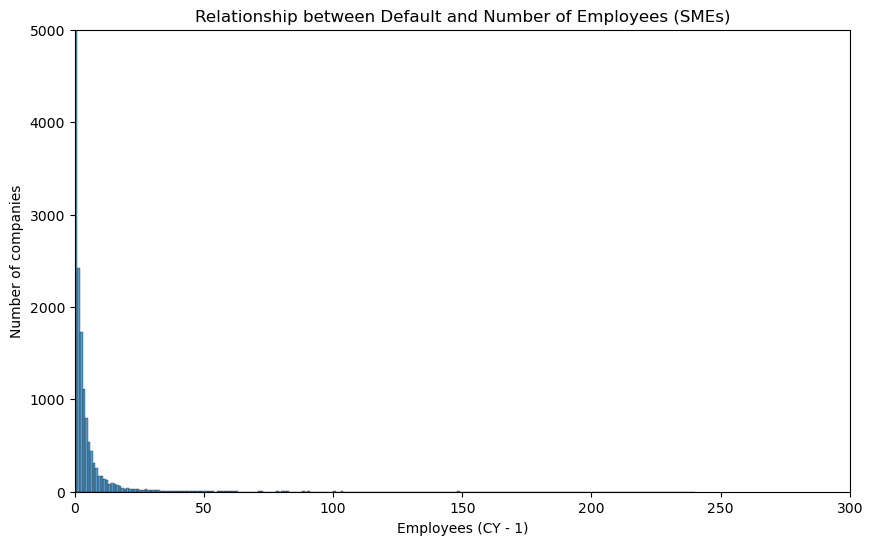

In [17]:
countplot(df=SMEs_2022_v2, x_variable='Dipendenti\nAnno - 1', x_label = 'Employees (CY - 1)')

## Train-Test split, Missing values and Outliers

In [ ]:
SMEs_2022_v2 = pd.read_csv(path_v2 +'/SMEs_2022_v2_new.csv')
LargeCompanies_2022_v2= pd.read_csv(path_v2 + '/LargeCompanies_2022_v2_new.csv')

In [ ]:
SMEs_2022_v2 = SMEs_2022_v2.drop(SMEs_2022_v2.columns[SMEs_2022_v2.columns.str.startswith('20')], axis=1)
LargeCompanies_2022_v2 = LargeCompanies_2022_v2.drop(LargeCompanies_2022_v2.columns[LargeCompanies_2022_v2.columns.str.startswith('20')], axis=1)


SMEs_2022_v2 = SMEs_2022_v2.loc[:, ~SMEs_2022_v2.columns.str.contains('Ultimo')]
LargeCompanies_2022_v2 = LargeCompanies_2022_v2.loc[:, ~LargeCompanies_2022_v2.columns.str.contains('Ultimo')]

In [ ]:
# SMEs_2022_v2 = set_types_columns(SMEs_2022_v2, string_columns)
LargeCompanies_2022_v2 = set_types_columns(LargeCompanies_2022_v2, string_columns)

In [ ]:
# float_cols_SMEs = SMEs_2022_v2.select_dtypes(include=['float64']).columns.to_list()
float_cols_LargeCompanies = LargeCompanies_2022_v2.select_dtypes(include=['float64']).columns.to_list()

In [ ]:
# Train - Test split for SMEs

X_SMEs = SMEs_2022_v2[float_cols_SMEs]
X_SMEs.drop(['Default'], axis=1, inplace=True)
y_SMEs = SMEs_2022_v2.loc[:, SMEs_2022_v2.columns == 'Default']

X_train_SMEs, X_test_SMEs, y_train_SMEs, y_test_SMEs = train_test_split(X_SMEs, y_SMEs, test_size=0.3, random_state=0)

In [ ]:
# Train - Test split for large companies

X_LargeCompanies = LargeCompanies_2022_v2[float_cols_LargeCompanies]
X_LargeCompanies.drop(['Default'], axis=1, inplace=True)
y_LargeCompanies = LargeCompanies_2022_v2.loc[:, LargeCompanies_2022_v2.columns == 'Default']

X_train_LargeCompanies, X_test_LargeCompanies, y_train_LargeCompanies, y_test_LargeCompanies = train_test_split(X_LargeCompanies, y_LargeCompanies, test_size=0.3, random_state=0)

In [ ]:
X_train_SMEs_v2, y_train_SMEs_v2 = preprocessing_df(X=X_train_SMEs,
                                                    y=y_train_SMEs,
                                                    threshold_col=0.8,
                                                    threshold_row=0.5,
                                                    method_missings_interpolation='cubic',
                                                    method_outliers_identification='interquantile_range',
                                                    threshold_outliers=3,
                                                    method_outliers_transformation='winsorization')
X_train_SMEs_v2

,Costo denaro a prestito (%)\n%\nAnno - 4,Costo denaro a prestito (%)\n%\nAnno - 3,Costo denaro a prestito (%)\n%\nAnno - 2,Costo denaro a prestito (%)\n%\nAnno - 1,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 2,Debiti v/banche su fatt. (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 1,Incidenza circolante operativo (%)\n%\nAnno - 4,...,EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1,Capitale circolante netto\nEUR\n(Rate at last closing date)\nAnno - 1,Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1,No of companies in corporate group,Società artigiana Encoded,PMI innovativa Encoded,Start-up innovativa Encoded,Operatore estero Encoded,Dipendenti\nAnno - 1,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 1
0,NaN,NaN,NaN,NaN,0.590000,0.790000,0.430000,0.000000,7.550000,311.760000,...,383301.0,3372118.0,3646676.0,2.0,0.0,0.0,0.0,0.0,2.0,5341096.0
1,NaN,NaN,NaN,NaN,30.395497,28.383688,14.360571,-36.387015,33.122398,231.345590,...,97453.0,-806663.0,1130956.0,4.0,0.0,0.0,0.0,0.0,0.0,4591383.0
2,NaN,NaN,NaN,NaN,37.523497,35.493688,19.940571,-36.387015,37.861398,140.020590,...,25091.0,121520.0,397212.0,0.0,0.0,0.0,0.0,0.0,0.0,680129.0
3,NaN,NaN,NaN,NaN,30.824748,29.276844,19.665286,-18.193507,29.092199,58.762795,...,11164.0,-12198.0,17985.0,0.0,0.0,0.0,0.0,0.0,0.0,48872.0
4,NaN,0.430000,0.680000,1.420000,19.150000,16.890000,16.030000,0.000000,14.140000,8.550000,...,560029.0,1928322.0,1636941.0,2.0,0.0,0.0,0.0,0.0,18.0,7847893.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424883,11.450666,0.154387,-1.602008,-5.093867,26.831027,-93.467006,38.960013,-113.516243,-19.159040,-1848.011190,...,66466.0,529733.0,1159763.0,0.0,0.0,0.0,0.0,0.0,4.0,1798881.0
424884,9.471887,0.390966,-1.552415,-5.168047,31.254951,-86.864292,41.380967,-117.755508,-22.796054,-1948.382116,...,216144.0,703775.0,662696.0,3.0,0.0,0.0,0.0,0.0,2.0,788486.0
424885,6.600360,1.730109,-0.731894,-2.244152,30.097284,-53.085362,33.892868,-80.790917,-12.240045,-1409.018372,...,74532.0,103630.0,106310.0,0.0,0.0,0.0,0.0,0.0,5.0,275410.0
424886,2.720000,4.400000,1.020000,4.560000,20.960000,15.420000,13.100000,12.020000,19.640000,-6.780000,...,67598.0,512332.0,113920.0,2.0,0.0,0.0,0.0,0.0,6.0,1918460.0


In [ ]:
X_test_SMEs_v2, y_test_SMEs_v2 = preprocessing_df(X=X_test_SMEs,
                                                  y=y_test_SMEs,
                                                  threshold_col=0.8,
                                                  threshold_row=0.5,
                                                  method_missings_interpolation='cubic',
                                                  method_outliers_identification='interquantile_range',
                                                  threshold_outliers=3,
                                                  method_outliers_transformation='winsorization')
X_test_SMEs_v2 = X_test_SMEs_v2[X_train_SMEs_v2.columns]
X_test_SMEs_v2

,Costo denaro a prestito (%)\n%\nAnno - 4,Costo denaro a prestito (%)\n%\nAnno - 3,Costo denaro a prestito (%)\n%\nAnno - 2,Costo denaro a prestito (%)\n%\nAnno - 1,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 2,Debiti v/banche su fatt. (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 1,Incidenza circolante operativo (%)\n%\nAnno - 4,...,EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1,Capitale circolante netto\nEUR\n(Rate at last closing date)\nAnno - 1,Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1,No of companies in corporate group,Società artigiana Encoded,PMI innovativa Encoded,Start-up innovativa Encoded,Operatore estero Encoded,Dipendenti\nAnno - 1,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 1
0,1.530000,1.240000,1.390000,1.180000,2.660000,4.360000,4.340000,87.910000,5.570000,0.280000,...,726980.0,360787.0,1786737.0,4.0,0.0,0.0,0.0,0.0,16.0,7234777.0
1,-14.896678,-0.088150,11.240000,12.840000,1.241535,1.560727,5.731349,0.030000,24.008514,18.060000,...,-36719.0,-91880.0,-33126.0,0.0,0.0,0.0,0.0,0.0,16.0,171698.0
2,-23.065434,-1.095187,13.112665,20.015756,-0.167449,-0.898604,5.676182,-46.232787,31.484571,6.068262,...,9881.0,22087.0,30472.0,2.0,1.0,0.0,0.0,0.0,2.0,362552.0
3,-24.688827,-1.807059,10.273998,23.417532,-1.366378,-2.814676,4.640423,-60.780403,30.729371,-23.140172,...,594.0,42542.0,42845.0,2.0,0.0,0.0,0.0,0.0,0.0,78854.0
4,-21.479419,-2.249716,5.990000,23.755590,-2.154674,-3.984169,3.090000,-53.514891,24.474114,-57.010259,...,6943.0,19439.0,10194.0,2.0,0.0,0.0,0.0,0.0,1.0,86437.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182216,20.309815,5.504114,21.536658,3.683833,-1.297537,4.088583,16.805109,5.050183,24.651405,-21.315336,...,20604.0,76677.0,48706.0,3.0,0.0,0.0,0.0,0.0,4.0,313205.0
182217,16.905815,5.933219,36.457481,6.463124,1.780000,3.050000,16.270000,0.000000,14.300000,13.050000,...,127380.0,74305.0,178057.0,2.0,0.0,0.0,0.0,0.0,7.0,1076137.0
182218,11.393907,6.099794,43.399974,8.369498,14.530000,6.181865,12.649336,0.000000,3.576373,142.740000,...,126397.0,-267373.0,389339.0,0.0,0.0,0.0,0.0,0.0,0.0,1192060.0
182219,6.260000,5.760000,34.241645,7.964582,8.220000,8.360000,5.932781,12.650000,-1.947590,22.930000,...,169378.0,292877.0,135724.0,2.0,0.0,0.0,0.0,0.0,12.0,1432569.0


In [ ]:
X_train_LargeCompanies_v2, y_train_LargeCompanies_v2 = preprocessing_df(X=X_train_LargeCompanies,
                                                                        y=y_train_LargeCompanies,
                                                                        threshold_col=1,
                                                                        threshold_row=1,
                                                                        method_missings_interpolation='cubic',
                                                                        method_outliers_identification='interquantile_range',
                                                                        threshold_outliers=3,
                                                                        method_outliers_transformation=None)
X_train_LargeCompanies_v2

,Capitalizzazione corrente\nEUR\n(Rate at last closing date),Capitale sociale (EUR),No of companies in corporate group,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 4,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 3,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 1,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 2,Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 4,Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 3,Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1,...,Margine di struttura\nEUR\n(Rate at last closing date)\nAnno - 2,Margine di struttura\nEUR\n(Rate at last closing date)\nAnno - 1,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 4,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,Società artigiana Encoded,PMI innovativa Encoded,Start-up innovativa Encoded,Operatore estero Encoded
850,NaN,3000000.0,9.0,121295735.0,112685849.0,130338748.0,122105061.0,36933213.0,38820319.0,40354032.0,...,7.233112e+06,1.191332e+07,8145330.0,9716254.0,9460074.0,10824402.0,0.0,0.0,0.0,0.0
1802,NaN,3500000.0,10.0,111854791.0,111728063.0,129016222.0,115526100.0,45237824.0,45343994.0,48239876.0,...,-2.978598e+07,-2.998043e+07,10611077.0,2166132.0,402221.0,3086333.0,0.0,0.0,0.0,0.0
980,NaN,5000000.0,41.0,83525013.0,117831588.0,164559643.0,129936290.0,53207758.0,78583695.0,106294673.0,...,4.534254e+07,6.292119e+07,15552942.0,9292798.0,3803649.0,22847541.0,0.0,0.0,0.0,0.0
655,NaN,12609000.0,315.0,165550540.0,596388000.0,669464000.0,698335000.0,38276920.0,91765000.0,117991000.0,...,-4.172050e+08,-3.685120e+08,43038868.0,46415000.0,50788000.0,51650000.0,0.0,0.0,0.0,0.0
1867,NaN,10000.0,133.0,18829420.0,27253834.0,66778267.0,34529138.0,8269390.0,12302698.0,1636062.0,...,-6.700302e+06,-4.931262e+06,4993007.0,6997585.0,-11493909.0,2179974.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,4.848255e+07,25000000.0,0.0,150301470.0,147956230.0,142830293.0,148521969.0,54393755.0,57585485.0,76745484.0,...,-3.524642e+07,-1.742244e+07,12331137.0,13372787.0,19567618.0,19577683.0,0.0,0.0,0.0,0.0
835,-1.510332e+10,82000.0,25.0,119406882.0,114109646.0,113332354.0,118986755.0,50057963.0,55142344.0,29693556.0,...,3.269755e+07,4.094763e+06,9173440.0,8967813.0,10085316.0,-20733120.0,0.0,0.0,0.0,0.0
1653,-2.304637e+08,10000000.0,11.0,186131592.0,191275960.0,208750250.0,203351231.0,57416392.0,78969112.0,97604387.0,...,9.299334e+07,9.433852e+07,25078548.0,23142836.0,18520196.0,22080584.0,0.0,0.0,0.0,0.0
2607,-2.223663e+08,7747000.0,2.0,50673335.0,47587529.0,51993433.0,50372418.0,21832089.0,23294797.0,23395326.0,...,-1.165590e+07,-1.444723e+07,5043148.0,4298914.0,3439605.0,4137291.0,0.0,0.0,0.0,0.0


In [ ]:
X_test_LargeCompanies_v2, y_test_LargeCompanies_v2 = preprocessing_df(X=X_test_LargeCompanies,
                                                                        y=y_test_LargeCompanies,
                                                                        threshold_col=1,
                                                                        threshold_row=1,
                                                                        method_missings_interpolation='cubic',
                                                                        method_outliers_identification='interquantile_range',
                                                                        threshold_outliers=3,
                                                                        method_outliers_transformation=None)
X_test_LargeCompanies_v2 = X_test_LargeCompanies_v2[X_train_LargeCompanies_v2.columns]
X_test_LargeCompanies_v2

,Capitalizzazione corrente\nEUR\n(Rate at last closing date),Capitale sociale (EUR),No of companies in corporate group,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 4,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 3,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 1,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 2,Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 4,Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 3,Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1,...,Margine di struttura\nEUR\n(Rate at last closing date)\nAnno - 2,Margine di struttura\nEUR\n(Rate at last closing date)\nAnno - 1,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 4,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2,Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1,Società artigiana Encoded,PMI innovativa Encoded,Start-up innovativa Encoded,Operatore estero Encoded
2507,NaN,1040000.0,20.0,46786203.0,47382115.0,67482294.0,58393046.0,26480066.0,27361026.0,32268510.0,...,6919862.0,11750986.0,4471449.0,4809192.0,4680115.0,7638320.0,0.0,0.0,0.0,0.0
781,7.307071e+07,96162195.0,28.0,390558000.0,365451000.0,431726000.0,400903000.0,134016000.0,148305000.0,154263000.0,...,-121431000.0,-97523000.0,29386000.0,28725000.0,24759000.0,24354000.0,0.0,0.0,0.0,0.0
1199,5.349882e+08,9828572.0,9.0,157909094.0,167153642.0,205188938.0,191202703.0,99492865.0,117362952.0,149828519.0,...,76713704.0,93655559.0,19740793.0,23056705.0,18860387.0,28630704.0,0.0,0.0,0.0,0.0
489,6.074811e+10,26000000.0,11.0,193519212.0,197919650.0,171481919.0,176224619.0,43603333.0,44407744.0,46326052.0,...,29385658.0,29326318.0,3465544.0,3112683.0,3757529.0,3571741.0,0.0,0.0,0.0,0.0
2705,2.497591e+08,500000.0,12.0,18937694.0,27332245.0,83009037.0,28375227.0,5763429.0,8967132.0,20647232.0,...,-191877.0,-38381156.0,3184646.0,3659275.0,1828361.0,837154.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,5.362599e+08,5000000.0,1105.0,94851000.0,148186000.0,171495000.0,158554000.0,28537000.0,34613000.0,38487000.0,...,-14146000.0,-27115000.0,5021000.0,8251000.0,10815000.0,11668000.0,0.0,0.0,0.0,0.0
1462,-1.617133e+08,2402241.0,82.0,115111000.0,155032000.0,164056000.0,154834000.0,67168000.0,72262000.0,78474000.0,...,5241000.0,5265000.0,10461000.0,17329000.0,15975000.0,16964000.0,0.0,0.0,0.0,0.0
1506,5.327840e+08,6000000.0,34.0,115431000.0,162904000.0,227896000.0,196075000.0,42646000.0,49306000.0,62232000.0,...,-39019000.0,-29603000.0,13460000.0,16887000.0,13178000.0,16928000.0,0.0,0.0,0.0,0.0
568,-1.669491e+09,10000.0,711.0,88882000.0,105912000.0,246485000.0,202591000.0,15405000.0,20191000.0,27753000.0,...,-93786000.0,-106440000.0,7339000.0,8246000.0,14316000.0,15423000.0,0.0,0.0,0.0,0.0


In [ ]:
# We assing the mean of the column to the remaining NaNs

for col in X_train_SMEs_v2.columns:
    X_train_SMEs_v2[col].fillna(X_train_SMEs_v2[col].mean(), inplace=True)

for col in X_test_SMEs_v2.columns:
    X_test_SMEs_v2[col].fillna(X_test_SMEs_v2[col].mean(), inplace=True)

for col in X_train_LargeCompanies_v2.columns:
    X_train_LargeCompanies_v2[col].fillna(X_train_LargeCompanies_v2[col].mean(), inplace=True)

for col in X_test_LargeCompanies_v2.columns:
    X_test_LargeCompanies_v2[col].fillna(X_test_LargeCompanies_v2[col].mean(), inplace=True)

In [ ]:
# X_train_SMEs_v2.to_csv(path_v2 + '/X_train_SMEs_v2.csv', index=False)
# y_train_SMEs_v2.to_csv(path_v2 + '/y_train_SMEs_v2.csv', index=False)
# X_test_SMEs_v2.to_csv(path_v2 + '/X_test_SMEs_v2.csv', index=False)
# y_test_SMEs_v2.to_csv(path_v2 + '/y_test_SMEs_v2.csv', index=False)

# X_train_LargeCompanies_v2.to_csv(path_v2 + '/X_train_LargeCompanies_v2.csv', index=False)
# y_train_LargeCompanies_v2.to_csv(path_v2 + '/y_train_LargeCompanies_v2.csv', index=False)
# X_test_LargeCompanies_v2.to_csv(path_v2 + '/X_test_LargeCompanies_v2.csv', index=False)
# y_test_LargeCompanies_v2.to_csv(path_v2 + '/y_test_LargeCompanies_v2.csv', index=False)

# Analysis

In [ ]:
X_train_SMEs_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/X_train_SMEs_v2.csv'))
y_train_SMEs_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/y_train_SMEs_v2.csv'))
X_test_SMEs_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/X_test_SMEs_v2.csv'))
y_test_SMEs_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/y_test_SMEs_v2.csv'))

X_train_LargeCompanies_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/X_train_LargeCompanies_v2.csv'))
y_train_LargeCompanies_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/y_train_LargeCompanies_v2.csv'))
X_test_LargeCompanies_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/X_test_LargeCompanies_v2.csv'))
y_test_LargeCompanies_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/y_test_LargeCompanies_v2.csv'))

In [ ]:
# Oversampling for the SMEs dataset

os = SMOTE(random_state=0)

# We oversample only the training data
os_X_train_SMEs, os_y_train_SMEs = os.fit_resample(X_train_SMEs_v2, y_train_SMEs_v2)

os_X_train_SMEs = pd.DataFrame(data=os_X_train_SMEs, columns=X_train_SMEs_v2.columns)
os_y_train_SMEs = pd.DataFrame(data=os_y_train_SMEs, columns=['Default'])

# we can Check the numbers of our data
print("The length of oversampled data is: ",
      len(os_X_train_SMEs))
print("Number of non-default companies in oversampled data: ",
      len(os_y_train_SMEs[os_y_train_SMEs['Default']==0]))
print("Proportion of non-default companies data in oversampled data is ",
      len(os_y_train_SMEs[os_y_train_SMEs['Default']==0])/len(os_X_train_SMEs))
print("\n")
print("Number of default companies in oversampled data: ",
      len(os_y_train_SMEs[os_y_train_SMEs['Default']==1]))
print("Proportion of default companies data in oversampled data is ",
      len(os_y_train_SMEs[os_y_train_SMEs['Default']==1])/len(os_X_train_SMEs))

The length of oversampled data is:  805922
Number of non-default companies in oversampled data:  402961
Proportion of non-default companies data in oversampled data is  0.5


Number of default companies in oversampled data:  402961
Proportion of default companies data in oversampled data is  0.5


In [ ]:
X_test_SMEs_v2.shape, y_test_SMEs_v2.shape

((182221, 146), (182221, 1))

In [ ]:
X_train_SMEs_v2.shape, y_train_SMEs_v2.shape

((424888, 146), (424888, 1))

In [ ]:
os_X_train_SMEs.shape, os_y_train_SMEs.shape

((805922, 146), (805922, 1))

In [ ]:
# Oversampling for the LargeCompanies dataset

os = SMOTE(random_state=0)

# We oversample only the training data
os_X_train_LargeCompanies, os_y_train_LargeCompanies = os.fit_resample(X_train_LargeCompanies_v2, y_train_LargeCompanies_v2)

os_X_train_LargeCompanies = pd.DataFrame(data=os_X_train_LargeCompanies, columns=X_train_LargeCompanies_v2.columns)
os_y_train_LargeCompanies = pd.DataFrame(data=os_y_train_LargeCompanies, columns=['Default'])

# we can Check the numbers of our data
print("The length of oversampled data is: ",
      len(os_X_train_LargeCompanies))
print("Number of non-default companies in oversampled data: ",
      len(os_y_train_LargeCompanies[os_y_train_LargeCompanies['Default']==0]))
print("Proportion of non-default companies data in oversampled data is ",
      len(os_y_train_LargeCompanies[os_y_train_LargeCompanies['Default']==0])/len(os_X_train_LargeCompanies))
print("\n")
print("Number of default companies in oversampled data: ",
      len(os_y_train_LargeCompanies[os_y_train_LargeCompanies['Default']==1]))
print("Proportion of default companies data in oversampled data is ",
      len(os_y_train_LargeCompanies[os_y_train_LargeCompanies['Default']==1])/len(os_X_train_LargeCompanies))

The length of oversampled data is:  3874
Number of non-default companies in oversampled data:  1937
Proportion of non-default companies data in oversampled data is  0.5


Number of default companies in oversampled data:  1937
Proportion of default companies data in oversampled data is  0.5


In [ ]:
X_test_LargeCompanies_v2.shape, y_test_LargeCompanies_v2.shape

((834, 147), (834, 1))

In [ ]:
X_train_LargeCompanies_v2.shape, y_train_LargeCompanies_v2.shape

((1945, 147), (1945, 1))

In [ ]:
os_X_train_LargeCompanies.shape, os_y_train_LargeCompanies.shape

((3874, 147), (3874, 1))

# Pipeline function

In [5]:
def build_and_evaluate_pipeline(X_train, y_train, X_test, y_test, model, scaling=True, selector_k=None,
                                model_param_grid=None, scoring='accuracy', cv=5):

    # Step 1: Define the steps in the pipeline

    if scaling == True:
        steps = [('scaler', StandardScaler())]
    else:
        steps = []

    if selector_k is not None:
        steps.append(('subset_selector', SelectKBest(score_func=f_classif, k=selector_k)))

    steps.append(('model', model))

    # Step 2: Create the pipeline
    pipeline = Pipeline(steps)

    # Step 3: Create the GridSearchCV object
    if model_param_grid is not None:
        grid_search = GridSearchCV(pipeline, {'model__' + k: v for k, v in model_param_grid.items()}, scoring=scoring, cv=cv)
        grid_search.fit(X_train, y_train)

        # Step 4: Get the best pipeline and its parameters
        best_pipeline = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Step 5: Use the best pipeline to make predictions
        predictions = best_pipeline.predict(X_test)

        model_used = best_pipeline

    else:
        # If no hyperparameter tuning is required
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)

        model_used = pipeline

    accuracy = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    return accuracy, cm, model_used

# Logistic Regression

In [ ]:
# Dictionary of possible parameters to be passed to the GridSearch

model_param_grid_logistic_regression = {"C": np.logspace(-3, 3, 7), "penalty": ["l1", "l2"]}

### SMEs

In [ ]:
accuracy_SMEs_logistic_regression_os, cm_SMEs_logistic_regression_os, model_SMEs_logistic_regression_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=LogisticRegression(),
    scaling=True,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_logistic_regression_os

0.7610868121676426

In [ ]:
cm_SMEs_logistic_regression_os

array([[131468,  41376],
       [  2159,   7218]])

In [ ]:
model_SMEs_logistic_regression_os

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

##### With subset selection:

In [ ]:
accuracy_SMEs_logistic_regression_os_ss, cm_SMEs_logistic_regression_os_ss, model_SMEs_logistic_regression_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=LogisticRegression(),
    scaling=True,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_logistic_regression_os_ss

0.7581069141317411

In [ ]:
cm_SMEs_logistic_regression_os_ss

array([[130906,  41938],
       [  2140,   7237]])

In [ ]:
model_SMEs_logistic_regression_os_ss

Pipeline(steps=[('scaler', StandardScaler()),
                ('subset_selector', SelectKBest(k=70)),
                ('model', LogisticRegression())])

### Large Companies

In [ ]:
accuracy_LargeCompanies_logistic_regression_os, cm_LargeCompanies_logistic_regression_os, model_LargeCompanies_logistic_regression_os = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=LogisticRegression(),
    scaling=True,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_logistic_regression_os

0.9676258992805755

In [ ]:
cm_LargeCompanies_logistic_regression_os

array([[807,  21],
       [  6,   0]], dtype=int64)

In [ ]:
model_LargeCompanies_logistic_regression_os

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

##### With subset selection:

In [ ]:
accuracy_LargeCompanies_logistic_regression_os_ss, cm_LargeCompanies_logistic_regression_os_ss, model_LargeCompanies_logistic_regression_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=LogisticRegression(),
    scaling=True,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_logistic_regression_os_ss

0.9664268585131894

In [ ]:
cm_LargeCompanies_logistic_regression_os_ss

array([[804,  24],
       [  4,   2]], dtype=int64)

In [ ]:
model_LargeCompanies_logistic_regression_os_ss

Pipeline(steps=[('scaler', StandardScaler()),
                ('subset_selector', SelectKBest(k=70)),
                ('model', LogisticRegression())])

# Linear Discriminant Analysis

In [ ]:
model_param_grid_lda = {'solver': ['svd', 'lsqr', 'eigen'],
                       'shrinkage':['auto', None]}

### SMEs

In [ ]:
accuracy_SMEs_lda_os, cm_SMEs_lda_os, model_SMEs_lda_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=LinearDiscriminantAnalysis(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_lda_os

0.7562904385334291

In [ ]:
cm_SMEs_lda_os

array([[130646,  42198],
       [  2211,   7166]])

In [ ]:
model_SMEs_lda_os

Pipeline(steps=[('model', LinearDiscriminantAnalysis())])

##### With subset selection:

In [ ]:
accuracy_SMEs_lda_os_ss, cm_SMEs_lda_os_ss, model_SMEs_lda_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=LinearDiscriminantAnalysis(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_lda_os_ss

0.752833098270781

In [ ]:
cm_SMEs_lda_os_ss

array([[130000,  42844],
       [  2195,   7182]])

In [ ]:
model_SMEs_lda_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', LinearDiscriminantAnalysis())])

### Large Companies

In [ ]:
accuracy_LargeCompanies_lda_os, cm_LargeCompanies_lda_os, model_LargeCompanies_lda_os = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=LinearDiscriminantAnalysis(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_lda_os

0.9040767386091128

In [ ]:
cm_LargeCompanies_lda_os

array([[752,  76],
       [  4,   2]], dtype=int64)

In [ ]:
model_LargeCompanies_lda_os

Pipeline(steps=[('model', LinearDiscriminantAnalysis())])

##### With subset selection:

In [ ]:
accuracy_LargeCompanies_lda_os_ss, cm_LargeCompanies_lda_os_ss, model_LargeCompanies_lda_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=LinearDiscriminantAnalysis(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_lda_os_ss

0.9124700239808153

In [ ]:
cm_LargeCompanies_lda_os_ss

array([[760,  68],
       [  5,   1]], dtype=int64)

In [ ]:
model_LargeCompanies_lda_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', LinearDiscriminantAnalysis())])

# KNN

In [ ]:
# Dictionary of possible parameters to be passed to the GridSearch

# k_range = list(range(4,7))
# model_param_grid_knn = dict(n_neighbors=k_range)

### SMEs

In [ ]:
accuracy_SMEs_knn_os, cm_SMEs_knn_os, model_SMEs_knn_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=KNeighborsClassifier(),
    scaling=True,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_knn_os

0.7937449580454503

In [ ]:
cm_SMEs_knn_os

array([[139121,  33723],
       [  3861,   5516]])

In [ ]:
model_SMEs_knn_os

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier())])

##### With subset selection:

In [ ]:
accuracy_SMEs_knn_os_ss, cm_SMEs_knn_os_ss, model_SMEs_knn_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=KNeighborsClassifier(),
    scaling=True,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_knn_os_ss

0.8136822868933877

In [ ]:
cm_SMEs_knn_os_ss

array([[142704,  30140],
       [  3811,   5566]])

In [ ]:
model_SMEs_knn_os_ss

Pipeline(steps=[('scaler', StandardScaler()),
                ('subset_selector', SelectKBest(k=70)),
                ('model', KNeighborsClassifier())])

### Large Companies

In [ ]:
accuracy_LargeCompanies_knn_os, cm_LargeCompanies_knn_os, model_LargeCompanies_knn_os = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=KNeighborsClassifier(),
    scaling=True,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_knn_os

0.9532374100719424

In [ ]:
cm_LargeCompanies_knn_os

array([[793,  35],
       [  4,   2]], dtype=int64)

In [ ]:
model_LargeCompanies_knn_os

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier())])

##### With subset selection:

In [ ]:
accuracy_LargeCompanies_knn_os_ss, cm_LargeCompanies_knn_os_ss, model_LargeCompanies_knn_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=KNeighborsClassifier(),
    scaling=True,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_knn_os_ss

0.9712230215827338

In [ ]:
cm_LargeCompanies_knn_os_ss

array([[808,  20],
       [  4,   2]], dtype=int64)

In [ ]:
model_LargeCompanies_knn_os_ss

Pipeline(steps=[('scaler', StandardScaler()),
                ('subset_selector', SelectKBest(k=70)),
                ('model', KNeighborsClassifier())])

# Decision tree

In [ ]:
model_param_grid_decision_tree = {
    'max_features': ['auto', 'sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.1, .01, .001],
    'max_depth' : [5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy', 'log_loss']
}

### SMEs

In [ ]:
accuracy_SMEs_dt_os, cm_SMEs_dt_os, model_SMEs_dt_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=DecisionTreeClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_dt_os

0.890534021874537

In [ ]:
cm_SMEs_dt_os

array([[158427,  14417],
       [  5530,   3847]])

In [ ]:
model_SMEs_dt_os

Pipeline(steps=[('model', DecisionTreeClassifier())])

##### With subset selection:

In [ ]:
accuracy_SMEs_dt_os_ss, cm_SMEs_dt_os_ss, model_SMEs_dt_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=DecisionTreeClassifier(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_dt_os_ss

0.8794815087174365

In [ ]:
cm_SMEs_dt_os_ss

array([[156102,  16742],
       [  5219,   4158]])

In [ ]:
model_SMEs_dt_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', DecisionTreeClassifier())])

### Large Companies

In [ ]:
accuracy_LargeCompanies_dt_os, cm_LargeCompanies_dt_os, model_LargeCompanies_dt_os = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=DecisionTreeClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_dt_os

0.9916067146282974

In [ ]:
cm_LargeCompanies_dt_os

array([[827,   1],
       [  6,   0]], dtype=int64)

In [ ]:
model_LargeCompanies_dt_os

Pipeline(steps=[('model', DecisionTreeClassifier())])

##### With subset selection:

In [ ]:
accuracy_LargeCompanies_dt_os_ss, cm_LargeCompanies_dt_os_ss, model_LargeCompanies_dt_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=DecisionTreeClassifier(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_dt_os_ss

0.9832134292565947

In [ ]:
cm_LargeCompanies_dt_os_ss

array([[820,   8],
       [  6,   0]], dtype=int64)

In [ ]:
model_LargeCompanies_dt_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', DecisionTreeClassifier())])

# Random forest

In [ ]:
# model_param_grid_rf = {
#     "n_estimators":[100, 200, 300],
#     "max_depth":[10, 20, 30, None],
#     "bootstrap":[True, False],
#     "min_samples_split":[2, 5, 10],
#     "min_samples_leaf":[1, 2, 4],
# }

### SMEs

In [ ]:
accuracy_SMEs_rf_os, cm_SMEs_rf_os, model_SMEs_rf_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=RandomForestClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_rf_os

0.9395623995038991

In [ ]:
cm_SMEs_rf_os

array([[166952,   5892],
       [  5121,   4256]])

In [ ]:
model_SMEs_rf_os

Pipeline(steps=[('model', RandomForestClassifier())])

In [ ]:
feature_names_SMEs_rf = [col for col in os_X_train_SMEs.columns]
importances_SMEs_rf = model_SMEs_rf_os['model'].feature_importances_

forest_importances_SMEs_rf = pd.Series(importances_SMEs_rf, index=feature_names_SMEs_rf)

forest_importances_SMEs_rf.sort_values(ascending=False).to_dict()

{'No of companies in corporate group': 0.05307354479433937,
 'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.05067552391779943,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.04725998752777482,
 'Dipendenti\nAnno - 1': 0.03583285590149762,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.030219429339699143,
 'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 2': 0.028398356186552384,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.026007499105353382,
 'Rapporto di indebitamento\nAnno - 1': 0.021549666261579278,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.018657863943342047,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.017843632488669645,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.01778688022725118,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 1': 0.016656562801482477,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 2': 0.016319345492519125,
 'Flusso di cassa di gest

##### With subset selection:

In [ ]:
accuracy_SMEs_rf_os_ss, cm_SMEs_rf_os_ss, model_SMEs_rf_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=RandomForestClassifier(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

NameError: name 'os_X_train_SMEs' is not defined

In [ ]:
accuracy_SMEs_rf_os_ss

NameError: name 'accuracy_SMEs_rf_os_ss' is not defined

In [ ]:
cm_SMEs_rf_os_ss

array([[165938,   6906],
       [  4955,   4422]])

In [ ]:
model_SMEs_rf_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', RandomForestClassifier())])

In [ ]:
model_SMEs_rf_os_ss.named_steps

{'subset_selector': SelectKBest(k=70), 'model': RandomForestClassifier()}

In [ ]:
feature_names_SMEs_rf_ss = [col for col in model_SMEs_rf_os_ss['subset_selector'].get_feature_names_out()]
importances_SMEs_rf_ss = model_SMEs_rf_os_ss['model'].feature_importances_

forest_importances_SMEs_rf_ss = pd.Series(importances_SMEs_rf_ss, index=feature_names_SMEs_rf_ss)

forest_importances_SMEs_rf_ss.sort_values(ascending=False).to_dict()

{'Dipendenti\nAnno - 1': 0.05677468845427505,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.050859988575248,
 'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.04956131607121373,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.04681122109894408,
 'Dipendenti\nAnno - 2': 0.033398516036638244,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.03299500246831738,
 'Rapporto di indebitamento\nAnno - 1': 0.03286320071915767,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.03092539088886872,
 'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 2': 0.028260271443854554,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.027063922434809134,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 1': 0.02605360579211784,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.024259185084593904,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 2': 0.022812319548825295,
 'Flusso di cassa di gestione\nEUR\n(Rate at

### Large Companies

In [ ]:
accuracy_LargeCompanies_rf_os, cm_LargeCompanies_rf_os, model_LargeCompanies_rf_os = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=RandomForestClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_rf_os

0.9928057553956835

In [ ]:
cm_LargeCompanies_rf_os

array([[828,   0],
       [  6,   0]], dtype=int64)

In [ ]:
model_LargeCompanies_rf_os

Pipeline(steps=[('model', RandomForestClassifier())])

In [ ]:
feature_names_LargeCompanies_rf = [col for col in os_X_train_LargeCompanies.columns]
importances_LargeCompanies_rf = model_LargeCompanies_rf_os['model'].feature_importances_

forest_importances_LargeCompanies_rf = pd.Series(importances_LargeCompanies_rf, index=feature_names_LargeCompanies_rf)

forest_importances_LargeCompanies_rf.sort_values(ascending=False).to_dict()

{'Debiti v/banche su fatt. (%)\n%\nAnno - 2': 0.09157021268553572,
 'Grado di copertura degli interessi passivi\n%\nAnno - 4': 0.08155928835199522,
 'No of companies in corporate group': 0.06498114948118999,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 2': 0.05676625813790308,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.052392028265105826,
 'Debt/Equity ratio\n%\nAnno - 1': 0.03753341508502497,
 'Grado di copertura degli interessi passivi\n%\nAnno - 3': 0.028825651068759738,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 4': 0.028780773587281025,
 'Posizione finanziaria netta\nEUR\n(Rate at last closing date)\nAnno - 1': 0.025306323131640048,
 'Debiti v/banche su fatt. (%)\n%\nAnno - 1': 0.024855335373889245,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 1': 0.022961829664136273,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 3': 0.02255166336983072,
 'Posizione finanziaria netta\nEUR\n(Rate at last closing date)\nAnno - 2': 0.020252483029535768,
 'Rotaz. cap. cir

##### With subset selection:

In [ ]:
accuracy_LargeCompanies_rf_os_ss, cm_LargeCompanies_rf_os_ss, model_LargeCompanies_rf_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=RandomForestClassifier(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_rf_os_ss

0.9928057553956835

In [ ]:
cm_LargeCompanies_rf_os_ss

array([[828,   0],
       [  6,   0]], dtype=int64)

In [ ]:
model_LargeCompanies_rf_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', RandomForestClassifier())])

In [ ]:
feature_names_LargeCompanies_rf_ss = [col for col in model_LargeCompanies_rf_os_ss['subset_selector'].get_feature_names_out()]
importances_LargeCompanies_rf_ss = model_LargeCompanies_rf_os_ss['model'].feature_importances_

forest_importances_LargeCompanies_rf_ss = pd.Series(importances_LargeCompanies_rf_ss, index=feature_names_LargeCompanies_rf_ss)

forest_importances_LargeCompanies_rf_ss.sort_values(ascending=False).to_dict()

{'Debiti v/banche su fatt. (%)\n%\nAnno - 2': 0.14891470471045298,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 2': 0.07423964565093116,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.05536036968539279,
 'Debt/Equity ratio\n%\nAnno - 1': 0.04995300148682302,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 3': 0.04846949503716355,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 4': 0.04791117664041024,
 'Debiti v/banche su fatt. (%)\n%\nAnno - 1': 0.03920746507930395,
 'Rendimento dipendenti\nAnno - 2': 0.03418137220996569,
 'Grado di copertura degli interessi passivi\n%\nAnno - 3': 0.031293722147183074,
 'Indice di indebitam. a lungo\n%\nAnno - 2': 0.030033284478805378,
 'Redditività del capitale proprio (ROE) (%)\n%\nAnno - 3': 0.028768807221601942,
 'Margine di tesoreria\nEUR\n(Rate at last closing date)\nAnno - 1': 0.027060358181905744,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 1': 0.026465595782046526,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 4': 0.02

# Gradient Boosting

In [ ]:
model_param_grid_gradient_boosting = {
    'loss':['log_loss', 'deviance', 'exponential'],
    'n_estimators': [10, 50, 100],
    'learning_rate': np.arange(0.0, 0.6)
}

### SMEs

In [ ]:
accuracy_SMEs_gb_os, cm_SMEs_gb_os, model_SMEs_gb_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=GradientBoostingClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_gb_os

0.9135500299087372

In [ ]:
cm_SMEs_gb_os

array([[161412,  11432],
       [  4321,   5056]])

In [ ]:
model_SMEs_gb_os

Pipeline(steps=[('model', GradientBoostingClassifier())])

In [ ]:
feature_names_SMEs_gb = [col for col in os_X_train_SMEs.columns]
importances_SMEs_gb = model_SMEs_gb_os['model'].feature_importances_

forest_importances_SMEs_gb = pd.Series(importances_SMEs_gb, index=feature_names_SMEs_gb)

forest_importances_SMEs_gb.sort_values(ascending=False).to_dict()

{'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.29588932927656714,
 'No of companies in corporate group': 0.1760211557762961,
 'Dipendenti\nAnno - 1': 0.10863312004912883,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.07310819810889313,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.04841245683244519,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.04691569700317682,
 'Capitale sociale (EUR)': 0.03977215267140046,
 'Rapporto di indebitamento\nAnno - 1': 0.027448008957676465,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.01916198831554403,
 'Indice di copertura delle immob. (finanziario)\n%\nAnno - 1': 0.01695309204461333,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.009672379096132125,
 'Società artigiana Encoded': 0.009354066265156998,
 'Dipendenti\nAnno - 4': 0.009331726468786104,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 3': 0.008550266391020711,
 'Indice di copertura delle im

##### With subset selection:

In [ ]:
accuracy_SMEs_gb_os_ss, cm_SMEs_gb_os_ss, model_SMEs_gb_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs_v2,
    y_test=y_test_SMEs_v2,
    model=GradientBoostingClassifier(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_gb_os_ss

0.8669308147798552

In [ ]:
cm_SMEs_gb_os_ss

array([[151840,  21004],
       [  3244,   6133]])

In [ ]:
model_SMEs_gb_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', GradientBoostingClassifier())])

### Large Companies

In [ ]:
accuracy_LargeCompanies_gb_os, cm_LargeCompanies_gb_os, model_LargeCompanies_gb_os = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=GradientBoostingClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_gb_os

0.9916067146282974

In [ ]:
cm_LargeCompanies_gb_os

array([[827,   1],
       [  6,   0]], dtype=int64)

In [ ]:
model_LargeCompanies_gb_os

Pipeline(steps=[('model', GradientBoostingClassifier())])

In [ ]:
feature_names_LargeCompanies_gb = [col for col in os_X_train_LargeCompanies.columns]
importances_LargeCompanies_gb = model_LargeCompanies_gb_os['model'].feature_importances_

forest_importances_LargeCompanies_gb = pd.Series(importances_LargeCompanies_gb, index=feature_names_LargeCompanies_gb)

forest_importances_LargeCompanies_gb.sort_values(ascending=False).to_dict()

{'Debiti v/banche su fatt. (%)\n%\nAnno - 2': 0.2468557967287706,
 'Grado di copertura degli interessi passivi\n%\nAnno - 4': 0.24369060046474086,
 'No of companies in corporate group': 0.19528627867581902,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 2': 0.10455452554868716,
 'Grado di copertura degli interessi passivi\n%\nAnno - 3': 0.06666057533547462,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.03484002128638756,
 'Posizione finanziaria netta\nEUR\n(Rate at last closing date)\nAnno - 2': 0.03470221881898834,
 'Rendimento dipendenti\nAnno - 2': 0.013005097319908216,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 1': 0.01083918306150338,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 4': 0.008741402414818219,
 'Debt/Equity ratio\n%\nAnno - 1': 0.007930769057160806,
 'Oneri finanz. su fatt. (%)\n%\nAnno - 3': 0.004919490924953301,
 'Margine di tesoreria\nEUR\n(Rate at last closing date)\nAnno - 1': 0.004275045190507892,
 'EBITDA\nEUR\n(Rate at last closing d

##### With subset selection:

In [ ]:
accuracy_LargeCompanies_gb_os_ss, cm_LargeCompanies_gb_os_ss, model_LargeCompanies_gb_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies_v2,
    y_test=y_test_LargeCompanies_v2,
    model=GradientBoostingClassifier(),
    scaling=False,
    selector_k=70,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_gb_os_ss

0.9904076738609112

In [ ]:
cm_LargeCompanies_gb_os_ss

array([[826,   2],
       [  6,   0]], dtype=int64)

In [ ]:
model_LargeCompanies_gb_os_ss

Pipeline(steps=[('subset_selector', SelectKBest(k=70)),
                ('model', GradientBoostingClassifier())])

# Support Vector Classifier

In [ ]:
model_param_grid_svc = {
                'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']
                       }

### SMEs

In [ ]:
accuracy_SMEs_svc_os, cm_SMEs_svc_os, model_SMEs_svc_os = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs,
    y_test=y_test_SMEs,
    model=SVC(),
    scaling=True,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

C:\Users\federico\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
accuracy_SMEs_svc_os

In [ ]:
cm_SMEs_svc_os

In [ ]:
model_SMEs_svc_os

##### With subset selection:

In [ ]:
accuracy_SMEs_svc_os_ss, cm_SMEs_svc_os_ss, model_SMEs_svc_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs,
    y_train=os_y_train_SMEs,
    X_test=X_test_SMEs,
    y_test=y_test_SMEs,
    model=SVC(),
    scaling=True,
    selector_k=100,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_SMEs_svc_os_ss

In [ ]:
cm_SMEs_svc_os_ss

In [ ]:
model_SMEs_svc_os_ss

### Large Companies

In [ ]:
accuracy_LargeCompanies_svc_os, cm_LargeCompanies_svc_os, model_LargeCompanies_svc_os = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies,
    y_test=y_test_LargeCompanies,
    model=SVC(),
    scaling=True,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_svc_os

In [ ]:
cm_LargeCompanies_svc_os

In [ ]:
model_LargeCompanies_svc_os

##### With subset selection:

In [ ]:
accuracy_LargeCompanies_svc_os_ss, cm_LargeCompanies_svc_os_ss, model_LargeCompanies_svc_os_ss = build_and_evaluate_pipeline(
    X_train=os_X_train_LargeCompanies,
    y_train=os_y_train_LargeCompanies,
    X_test=X_test_LargeCompanies,
    y_test=y_test_LargeCompanies,
    model=SVC(),
    scaling=True,
    selector_k=100,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [ ]:
accuracy_LargeCompanies_svc_os_ss

In [ ]:
cm_LargeCompanies_svc_os_ss

In [ ]:
model_LargeCompanies_svc_os_ss

# Models comparison

In [ ]:
Models = ['Logistic Regression', 'LDA', 'KNN', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
Accuracy_SMEs = [0.7610868121676426, 0.7562904385334291, 0.7937449580454503, 0.890534021874537, 0.9395623995038991, 0.9135500299087372]
Accuracy_SMEs_ss = [0.7581069141317411, 0.752833098270781, 0.8136822868933877, 0.8794815087174365, 0.934908709753541, 0.8669308147798552]
Accuracy_LargeCompanies = [0.7233208622839836, 0.7367717797969, 0.7496882237662569, 0.8406378050953145, 0.8931943702120079, 0.8809014787101371]
Accuracy_LargeCompanies_ss = [0.7224300730447176, 0.7377516479600926, 0.7464813825048994, 0.8415285943345805, 0.892481738820595, 0.874933190807055]

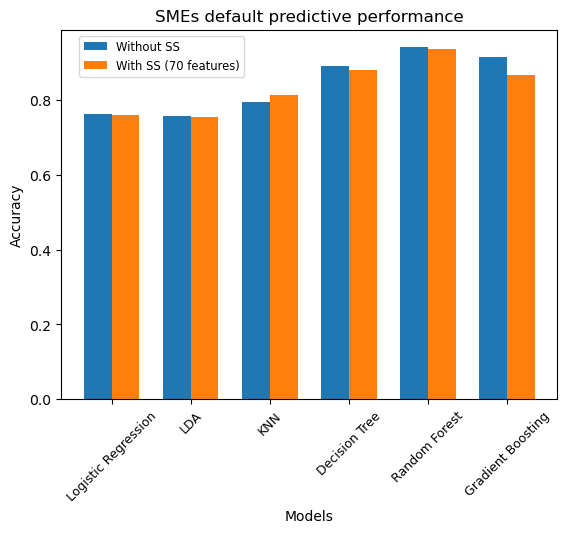

In [ ]:
fig, ax = plt.subplots()

x = np.arange(0, len(Models))
width = 0.35

ax.bar(x-width/2, Accuracy_SMEs, width, label='Without SS')
ax.bar(x+width/2, Accuracy_SMEs_ss, width, label='With SS (70 features)')

plt.xticks(x, Models)

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')

plt.tick_params(axis='x', labelsize=9)
plt.tick_params(axis='y', labelsize=10)

plt.xticks(rotation=45)


ax.set_title('SMEs default predictive performance')

fig.legend(bbox_to_anchor=(0.42,0.88), fontsize='small')
plt.show()

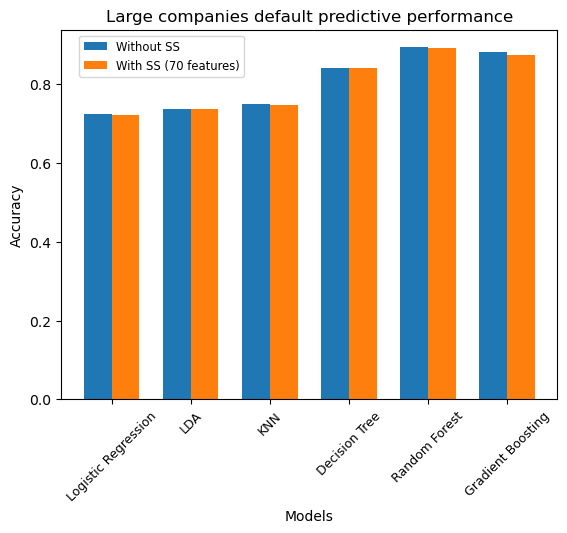

In [ ]:
fig, ax = plt.subplots()

x = np.arange(0, len(Models))
width = 0.35

ax.bar(x-width/2, Accuracy_LargeCompanies, width, label='Without SS')
ax.bar(x+width/2, Accuracy_LargeCompanies_ss, width, label='With SS (70 features)')

plt.xticks(x, Models)

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')

plt.tick_params(axis='x', labelsize=9)
plt.tick_params(axis='y', labelsize=10)

plt.xticks(rotation=45)


ax.set_title('Large companies default predictive performance')

fig.legend(bbox_to_anchor=(0.42,0.88), fontsize='small')
plt.show()

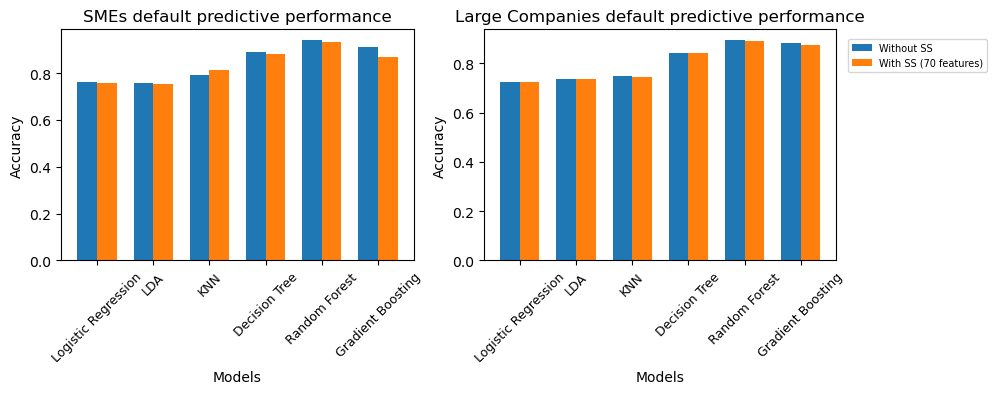

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=False, figsize=(10,3))
gs = gridspec.GridSpec(ncols=2, nrows=1)

ax1 = fig.add_subplot(gs[0,0])
ax2= fig.add_subplot(gs[0,1])

x = np.arange(0, len(Models))
width = 0.35

ax1.bar(x-width/2, Accuracy_SMEs, width, label='Without SS')
ax1.bar(x+width/2, Accuracy_SMEs_ss, width, label='With SS (70 features)')
ax1.set_xticks(x, Models, rotation=45)
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', labelsize=9)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_title('SMEs default predictive performance')
# ax1.legend(bbox_to_anchor=(0.42,0.88), fontsize='small')

ax2.bar(x-width/2, Accuracy_LargeCompanies, width, label='Without SS')
ax2.bar(x+width/2, Accuracy_LargeCompanies_ss, width, label='With SS (70 features)')
ax2.set_xticks(x, Models, rotation=45)
ax2.set_xlabel('Models')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='x', labelsize=9)
ax2.tick_params(axis='y', labelsize=10)
ax2.set_title('Large Companies default predictive performance')
ax2.legend(bbox_to_anchor=(1.02,0.98), fontsize=7)

# fig.legend(bbox_to_anchor=(0.42,0.88), fontsize='small')

In [ ]:
best_features_SMEs_rf = {
    'Num. of companies in corporate group': 0.05307354479433937,
    'Profit Margin': 0.05067552391779943,
    'EBITDA': 0.04725998752777482,
    'Employees': 0.03583285590149762,
    'Return on Total Assets (ROA) (%)': 0.030219429339699143,
    'Profit Margin (CY - 2)': 0.028398356186552384,
    'Operating Cash Flow': 0.026007499105353382,
    'Debt Ratio': 0.021549666261579278,
    'Net Worth': 0.018657863943342047,
    'Gross Working Capital Turnover (times)': 0.017843632488669645,
    'EBITDA/Sales (%)':0.01778688022725118
}

best_features_LargeCompanies_rf = {
    'Operating Cash Flow': 0.04731683079780533,
    'EBITDA': 0.04479152813157652,
    'Return on Total Assets (ROA) (%)': 0.040028416648532676,
    'Profit Margin': 0.036962865566532485,
    'Num. of companies in corporate group': 0.03458975374876477,
    'Debt Ratio': 0.027263639450532916,
    'EBITDA/Sales (%)': 0.025695678908120755,
    'Net Worth': 0.023239194282967363,
    'Net Worth (CY - 2)': 0.019741677423678883,
    'Gross Working Capital Turnover (times)': 0.019592516551408364,
    'Employees (CY - 3)': 0.01800421538805773
}

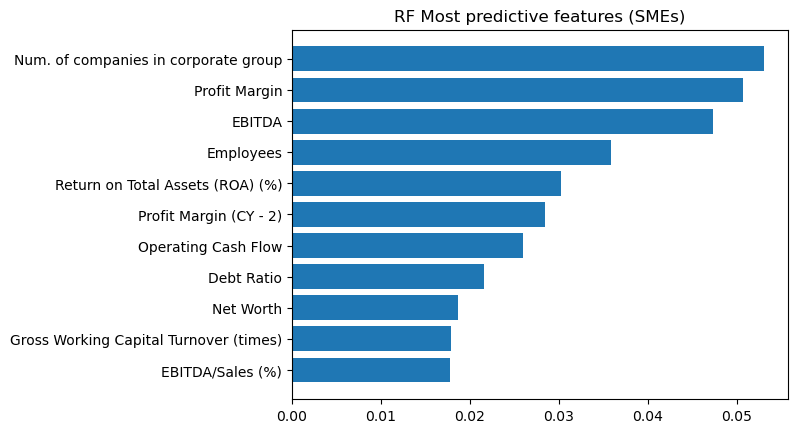

In [ ]:
fig, ax = plt.subplots()

ax.barh(list(best_features_SMEs_rf.keys())[::-1],
       list(best_features_SMEs_rf.values())[::-1])
ax.set_title('RF Most predictive features (SMEs)')
plt.show()

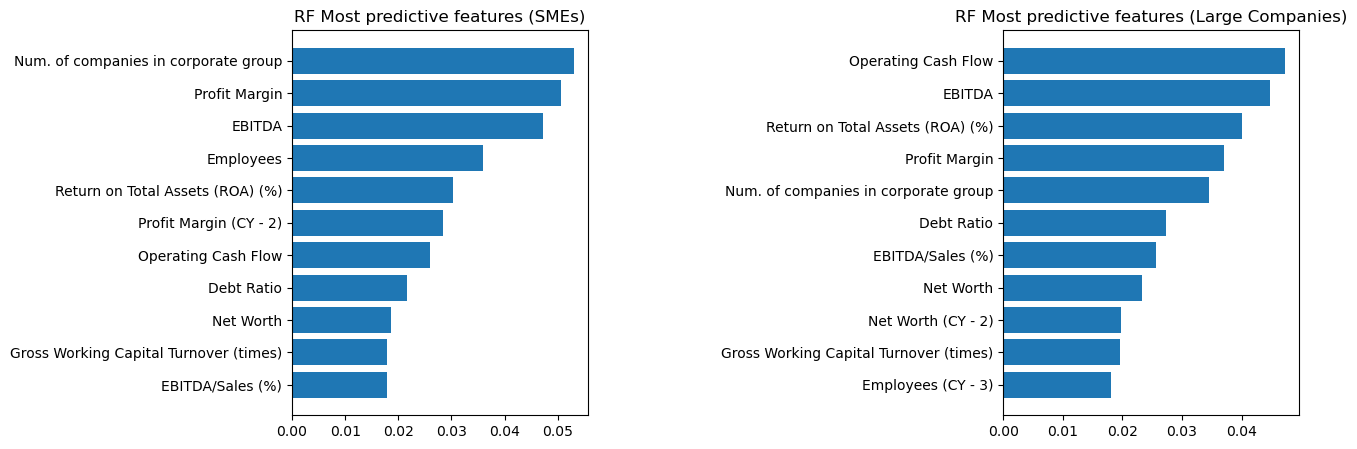

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=False, figsize=(13,5))
gs = gridspec.GridSpec(ncols=3, nrows=1)

ax1 = fig.add_subplot(gs[0,0])
ax2= fig.add_subplot(gs[0,2])

x = np.arange(0, len(Models))
width = 0.35

ax1.barh(list(best_features_SMEs_rf.keys())[::-1],
       list(best_features_SMEs_rf.values())[::-1])
ax1.set_title('RF Most predictive features (SMEs)')

ax2.barh(list(best_features_LargeCompanies_rf.keys())[::-1],
       list(best_features_LargeCompanies_rf.values())[::-1])
ax2.set_title('RF Most predictive features (Large Companies)')


plt.show()

# Istat data

In [41]:
istat_data = pd.read_csv(path_tesi_folder +'/ISTAT/istat_data.csv')

In [42]:
SMEs_2022_v2 = remove_Unnamed_columns(pd.read_csv(path_v2 + '/SMEs_2022_v2_new.csv'))
LargeCompanies_2022_v2  = remove_Unnamed_columns(pd.read_csv(path_v2 + '/LargeCompanies_2022_v2_new.csv'))

In [43]:
SMEs_2022_v2 = SMEs_2022_v2.drop(SMEs_2022_v2.columns[SMEs_2022_v2.columns.str.startswith('20')], axis=1)
LargeCompanies_2022_v2 = LargeCompanies_2022_v2.drop(LargeCompanies_2022_v2.columns[LargeCompanies_2022_v2.columns.str.startswith('20')], axis=1)


SMEs_2022_v2 = SMEs_2022_v2.loc[:, ~SMEs_2022_v2.columns.str.contains('Ultimo')]
LargeCompanies_2022_v2 = LargeCompanies_2022_v2.loc[:, ~LargeCompanies_2022_v2.columns.str.contains('Ultimo')]

In [44]:
SMEs_2022_v2 = set_types_columns(SMEs_2022_v2, string_columns)
LargeCompanies_2022_v2 = set_types_columns(LargeCompanies_2022_v2, string_columns)

In [45]:
float_cols_SMEs = SMEs_2022_v2.select_dtypes(include=['float64']).columns.to_list()
float_cols_LargeCompanies = LargeCompanies_2022_v2.select_dtypes(include=['float64']).columns.to_list()

In [46]:
istat_data

,ITTER107,Territorio,TIPO_DATO29,Variabile,ATECO_2007,Ateco 2007,TIME,Seleziona periodo,Value,Flag Codes,Flags
0,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),2018,2018,0.0,NaN,NaN
1,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),2019,2019,0.0,NaN,NaN
2,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),2020,2020,0.0,NaN,NaN
3,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),2021,2021,0.0,NaN,NaN
4,IT,Italia,11110,imprese,22,articoli in gomma e materie plastiche,2018,2018,9522.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3691,IT,Italia,12150,valore aggiunto al costo dei fattori (migliaia...,77,attività di noleggio e leasing operativo,2021,2021,8683272.0,NaN,NaN
3692,IT,Italia,16150,ore lavorate dai dipendenti (migliaia),77,attività di noleggio e leasing operativo,2018,2018,60623.0,NaN,NaN
3693,IT,Italia,16150,ore lavorate dai dipendenti (migliaia),77,attività di noleggio e leasing operativo,2019,2019,62288.0,NaN,NaN
3694,IT,Italia,16150,ore lavorate dai dipendenti (migliaia),77,attività di noleggio e leasing operativo,2020,2020,50584.0,NaN,NaN


In [47]:
istat_data_pivot = istat_data.pivot_table(values='Value', index=['ATECO_2007'],
                       columns=['TIME', 'Variabile'], aggfunc="sum")

In [48]:
istat_data_pivot

TIME                                                2018  \
Variabile  acquisto di beni e servizi (migliaia di euro)   
ATECO_2007                                                 
5                                                    0.0   
6                                              3728559.0   
7                                                   63.0   
8                                              1772722.0   
9                                               269769.0   
...                                                  ...   
91                                              274511.0   
92                                            10527751.0   
93                                             5558798.0   
95                                             1550439.0   
96                                             7375798.0   

TIME                                               \
Variabile  costi del personale (migliaia di euro)   
ATECO_2007                                          
5                                             0.0   
6                                        202948.0   
7                                            81.0   
8                                        544692.0   
9                                        130224.0   
...                                           ...   
91                                       289449.0   
92                                      1136726.0   
93                                      2950245.0   
95                                       467004.0   
96                                      4382294.0   

TIME                                               \
Variabile  fatturato (migliaia di euro)   imprese   
ATECO_2007                                          
5                                   0.0       0.0   
6                             5709248.0       9.0   
7                                  31.0       3.0   
8                             2741343.0    1793.0   
9                              398903.0      37.0   
...                                 ...       ...   
91                             625643.0     989.0   
92                           15097186.0    9265.0   
93                            7475398.0   30924.0   
95                            2570933.0   25108.0   
96                           15530513.0  188745.0   

TIME                                                                \
Variabile  investimenti lordi in beni materiali (migliaia di euro)   
ATECO_2007                                                           
5                                                         0.0        
6                                                    941674.0        
7                                                        11.0        
8                                                    153811.0        
9                                                     33347.0        
...                                                       ...        
91                                                    19019.0        
92                                                   276316.0        
93                                                   432934.0        
95                                                    54142.0        
96                                                   945398.0        

TIME                                                                         \
Variabile  lavoratori dipendenti margine operativo lordo (migliaia di euro)   
ATECO_2007                                                                    
5                            0.0                                        0.0   
6                         2287.0                                  1370403.0   
7                            2.0                                       14.0   
8                        12251.0                                   464265.0   
9                         1526.0                                     2547.0   
...                          ...                            

In [49]:
l = []
for col in istat_data_pivot.columns:
    l.append(str(col[0]) + '_' + col[1])

istat_data_pivot.columns = l

In [50]:
istat_data_pivot.index = istat_data_pivot.index.astype(str)
istat_data_pivot

,2018_acquisto di beni e servizi (migliaia di euro),2018_costi del personale (migliaia di euro),2018_fatturato (migliaia di euro),2018_imprese,2018_investimenti lordi in beni materiali (migliaia di euro),2018_lavoratori dipendenti,2018_margine operativo lordo (migliaia di euro),2018_occupati,2018_ore lavorate dai dipendenti (migliaia),2018_salari e stipendi (migliaia di euro),...,2021_fatturato (migliaia di euro),2021_imprese,2021_investimenti lordi in beni materiali (migliaia di euro),2021_lavoratori dipendenti,2021_margine operativo lordo (migliaia di euro),2021_occupati,2021_ore lavorate dai dipendenti (migliaia),2021_salari e stipendi (migliaia di euro),2021_valore aggiunto al costo dei fattori (migliaia di euro),2021_valore della produzione (migliaia di euro)
ATECO_2007,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3728559.0,202948.0,5709248.0,9.0,941674.0,2287.0,1370403.0,2287.0,3804.0,144501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,63.0,81.0,31.0,3.0,11.0,2.0,14.0,2.0,3.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1772722.0,544692.0,2741343.0,1793.0,153811.0,12251.0,464265.0,13890.0,20332.0,373271.0,...,3041148.0,1633.0,164826.0,12203.0,544373.0,13575.0,20370.0,389689.0,1111311.0,3155170.0
9,269769.0,130224.0,398903.0,37.0,33347.0,1526.0,2547.0,1537.0,2689.0,92171.0,...,490893.0,30.0,13064.0,1286.0,138229.0,1298.0,2081.0,80356.0,247585.0,512175.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,274511.0,289449.0,625643.0,989.0,19019.0,10844.0,64947.0,11537.0,14422.0,211995.0,...,527440.0,1125.0,9494.0,11044.0,71450.0,11836.0,13913.0,195491.0,337578.0,573603.0
92,10527751.0,1136726.0,15097186.0,9265.0,276316.0,31768.0,2113070.0,42818.0,45803.0,831483.0,...,14974691.0,7936.0,152335.0,28278.0,1933362.0,37223.0,28527.0,573942.0,2750179.0,15171334.0
93,5558798.0,2950245.0,7475398.0,30924.0,432934.0,61196.0,1716488.0,91858.0,76779.0,2434448.0,...,5160297.0,29529.0,943201.0,53981.0,424377.0,80717.0,61682.0,2675143.0,3633897.0,8728727.0


In [51]:
anni = ['2021', '2020', '2019']
istat_data_pivot_v2 = istat_data_pivot.copy()

for year in anni:
    for col in istat_data_pivot.columns:
        if col.startswith(year):
            end_col = col.replace(year + '_', "")
            year_minus_one = str(int(year) - 1)
            year_variation = year_minus_one + '_' + year

            previous_data = istat_data_pivot_v2[year_minus_one + '_' + end_col]
            current_data = istat_data_pivot_v2[col]
            istat_data_pivot_v2[year_variation + '_' + end_col] = (current_data - previous_data) / previous_data

istat_data_pivot_v2.drop(istat_data_pivot.columns, axis=1, inplace=True)
istat_data_pivot_v2

,2020_2021_acquisto di beni e servizi (migliaia di euro),2020_2021_costi del personale (migliaia di euro),2020_2021_fatturato (migliaia di euro),2020_2021_imprese,2020_2021_investimenti lordi in beni materiali (migliaia di euro),2020_2021_lavoratori dipendenti,2020_2021_margine operativo lordo (migliaia di euro),2020_2021_occupati,2020_2021_ore lavorate dai dipendenti (migliaia),2020_2021_salari e stipendi (migliaia di euro),...,2018_2019_fatturato (migliaia di euro),2018_2019_imprese,2018_2019_investimenti lordi in beni materiali (migliaia di euro),2018_2019_lavoratori dipendenti,2018_2019_margine operativo lordo (migliaia di euro),2018_2019_occupati,2018_2019_ore lavorate dai dipendenti (migliaia),2018_2019_salari e stipendi (migliaia di euro),2018_2019_valore aggiunto al costo dei fattori (migliaia di euro),2018_2019_valore della produzione (migliaia di euro)
ATECO_2007,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.152212,0.222222,-0.138528,-0.042851,-0.203129,-0.042851,-0.020768,0.035232,-0.171736,-0.149615
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.064516,0.000000,15.363636,0.000000,0.357143,0.000000,0.000000,0.352941,0.210526,0.263158
8,0.205985,0.111854,0.167434,-0.037714,-0.187997,0.013033,0.261641,0.001623,0.125290,0.119339,...,0.013266,-0.017847,0.029445,-0.010040,-0.061598,-0.011663,-0.000443,0.024856,-0.013828,0.019261
9,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.060416,-0.027027,-0.498126,0.026868,-3.197487,0.027977,0.006694,0.059400,-0.004835,0.051915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.122556,0.101300,0.276900,0.108374,-0.833424,0.020608,13.062192,0.023698,0.144538,0.117174,...,0.054651,0.019211,-0.293075,0.025821,-0.060757,0.027737,0.013590,0.038874,0.026578,0.074494
92,0.416847,0.059022,0.344233,-0.017335,0.164917,-0.016554,0.421531,-0.016617,0.003624,0.052469,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
93,0.088773,0.199541,0.156800,0.008780,3.603451,0.015387,-0.432123,-0.017635,0.130038,0.190838,...,0.039469,0.020599,0.609522,0.025672,-0.081883,0.026443,0.028497,0.124272,0.046726,0.049332


In [52]:
LargeCompanies_2022_v2['ATECO 2007\ncodice'] = LargeCompanies_2022_v2['ATECO 2007\ncodice'].astype(str).str[:2]
SMEs_2022_v2['ATECO 2007\ncodice'] = SMEs_2022_v2['ATECO 2007\ncodice'].astype(str).str[:2]

In [53]:
LargeCompanies_istat = pd.merge(LargeCompanies_2022_v2, istat_data_pivot_v2, left_on='ATECO 2007\ncodice', right_on='ATECO_2007', how='inner')
LargeCompanies_istat

,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Capitalizzazione corrente\nEUR\n(Rate at last closing date),Capitale sociale (EUR),No of companies in corporate group,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 4,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 3,...,2018_2019_fatturato (migliaia di euro),2018_2019_imprese,2018_2019_investimenti lordi in beni materiali (migliaia di euro),2018_2019_lavoratori dipendenti,2018_2019_margine operativo lordo (migliaia di euro),2018_2019_occupati,2018_2019_ore lavorate dai dipendenti (migliaia),2018_2019_salari e stipendi (migliaia di euro),2018_2019_valore aggiunto al costo dei fattori (migliaia di euro),2018_2019_valore della produzione (migliaia di euro)
0,ENI S.P.A.,484960588,Lazio,Attiva,Società di capitale,4.981534e+10,4.005359e+09,544.0,8.120758e+10,8.329573e+10,...,0.193974,-0.026316,0.438672,0.049032,0.371509,0.049188,0.054053,0.076317,0.209283,0.224935
1,ISAB S.R.L.,1629050897,Sicilia,Attiva,Società di capitale,NaN,5.000000e+07,4.0,1.718420e+09,1.719229e+09,...,0.193974,-0.026316,0.438672,0.049032,0.371509,0.049188,0.054053,0.076317,0.209283,0.224935
2,ITALIANA PETROLI S.P.A.,51570893,Lazio,Attiva,Società di capitale,NaN,4.766531e+07,19.0,1.423303e+09,3.066444e+09,...,0.193974,-0.026316,0.438672,0.049032,0.371509,0.049188,0.054053,0.076317,0.209283,0.224935
3,SONATRACH RAFFINERIA ITALIANA S.R.L.,10410680960,Lombardia,Attiva,Società di capitale,NaN,5.000000e+08,132.0,1.711555e+09,2.359169e+09,...,0.193974,-0.026316,0.438672,0.049032,0.371509,0.049188,0.054053,0.076317,0.209283,0.224935
4,IPLOM S.P.A.,2242120109,Liguria,Attiva,Società di capitale,NaN,8.500000e+07,9.0,5.763716e+08,5.562689e+08,...,0.193974,-0.026316,0.438672,0.049032,0.371509,0.049188,0.054053,0.076317,0.209283,0.224935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678,COSTA EDUTAINMENT S.P.A.,3362540100,Emilia-Romagna,Attiva,Società di capitale,NaN,9.521962e+06,4.0,8.616787e+07,8.461916e+07,...,0.054651,0.019211,-0.293075,0.025821,-0.060757,0.027737,0.013590,0.038874,0.026578,0.074494
2679,OPERA-LABORATORI FIORENTINI SOCIETA' PER AZIONI,1643350489,Toscana,Attiva,Società di capitale,NaN,6.759035e+06,14.0,5.792407e+07,5.883342e+07,...,0.054651,0.019211,-0.293075,0.025821,-0.060757,0.027737,0.013590,0.038874,0.026578,0.074494
2680,FONDAZIONE ARENA DI VERONA,231130238,Veneto,Attiva,Società di capitale,NaN,NaN,2.0,6.800690e+07,6.779765e+07,...,0.104850,0.005339,-0.415328,0.039613,0.064003,0.016550,0.050325,0.097378,0.073144,0.102459
2681,FONDAZIONE TEATRO MASSIMO,262030828,Sicilia,Attiva,Società di capitale,NaN,NaN,0.0,7.583652e+07,7.408600e+07,...,0.104850,0.005339,-0.415328,0.039613,0.064003,0.016550,0.050325,0.097378,0.073144,0.102459


In [54]:
SMEs_istat = pd.merge(SMEs_2022_v2, istat_data_pivot_v2, left_on='ATECO 2007\ncodice', right_on='ATECO_2007', how='inner')
SMEs_istat

,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Capitalizzazione corrente\nEUR\n(Rate at last closing date),Capitale sociale (EUR),No of companies in corporate group,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 4,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 3,...,2018_2019_fatturato (migliaia di euro),2018_2019_imprese,2018_2019_investimenti lordi in beni materiali (migliaia di euro),2018_2019_lavoratori dipendenti,2018_2019_margine operativo lordo (migliaia di euro),2018_2019_occupati,2018_2019_ore lavorate dai dipendenti (migliaia),2018_2019_salari e stipendi (migliaia di euro),2018_2019_valore aggiunto al costo dei fattori (migliaia di euro),2018_2019_valore della produzione (migliaia di euro)
0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,NaN,100000.0,11.0,8174582.0,10286895.0,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
1,REPLATZ SRL,2806270241,Veneto,Attiva,Società di capitale,NaN,80000.0,0.0,5803514.0,6573831.0,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
2,VITTORIA BET 2009 S.R.L.,1691320475,Toscana,Attiva,Società di capitale,NaN,500000.0,20.0,3237596.0,3961400.0,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
3,MULTIGIOCO S.R.L.,11145161003,Lazio,Attiva,Società di capitale,NaN,500000.0,9.0,2881528.0,2930780.0,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
4,GI.LU.PI. S.R.L.,3350310755,Puglia,Attiva,Società di capitale,NaN,250000.0,3.0,14561008.0,16301080.0,...,-0.077348,-0.107285,-0.117550,-0.040953,-0.076528,-0.065743,-0.043163,0.003559,-0.046826,-0.079199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694961,HELIX S.R.L.S.,5842220872,Sicilia,Attiva,Società di capitale,NaN,1800.0,2.0,NaN,NaN,...,0.093894,-0.031987,0.146974,0.110329,0.004759,-0.017943,0.101903,0.136770,0.014192,0.092715
694962,CLINICA VETERINARIA CITTA' DI FASANO S.R.L. SO...,2649020746,Puglia,Attiva,Società di capitale,NaN,10000.0,2.0,NaN,NaN,...,0.093894,-0.031987,0.146974,0.110329,0.004759,-0.017943,0.101903,0.136770,0.014192,0.092715
694963,CENTRO CHIRURGICO VETERINARIO BOLOGNESE S.R.L....,2720471206,Emilia-Romagna,Attiva,Società di capitale,NaN,10000.0,4.0,299969.0,298309.0,...,0.093894,-0.031987,0.146974,0.110329,0.004759,-0.017943,0.101903,0.136770,0.014192,0.092715
694964,PICCOLO ZOO S.R.L. IN LIQUIDAZIONE,3514280373,Emilia-Romagna,In liquidazione,Società di capitale,NaN,10000.0,3.0,559038.0,545761.0,...,0.093894,-0.031987,0.146974,0.110329,0.004759,-0.017943,0.101903,0.136770,0.014192,0.092715


In [55]:
istat_data_250_or_more = pd.read_csv(path_tesi_folder +'/ISTAT/istat_data_250_or_more.csv')
istat_data_250_or_more

,ITTER107,Territorio,TIPO_DATO29,Variabile,ATECO_2007,Ateco 2007,CLLVT,Classe di addetti,TIME,Seleziona periodo,Value,Flag Codes,Flags
0,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),W_GE250,250 e più,2018,2018,0.0,NaN,NaN
1,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),W_GE250,250 e più,2019,2019,0.0,NaN,NaN
2,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),W_GE250,250 e più,2020,2020,0.0,NaN,NaN
3,IT,Italia,11110,imprese,5,estrazione di carbone (esclusa torba),W_GE250,250 e più,2021,2021,0.0,NaN,NaN
4,IT,Italia,11110,imprese,6,estrazione di petrolio greggio e di gas naturale,W_GE250,250 e più,2018,2018,NaN,c,dato oscurato per la tutela del segreto statis...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,IT,Italia,12150,valore aggiunto al costo dei fattori (migliaia...,14,articoli di abbigliamento (anche in pelle e in...,W_GE250,250 e più,2021,2021,4011667.0,NaN,NaN
3412,IT,Italia,12170,margine operativo lordo (migliaia di euro),14,articoli di abbigliamento (anche in pelle e in...,W_GE250,250 e più,2018,2018,884365.0,NaN,NaN
3413,IT,Italia,12170,margine operativo lordo (migliaia di euro),14,articoli di abbigliamento (anche in pelle e in...,W_GE250,250 e più,2019,2019,1453283.0,NaN,NaN
3414,IT,Italia,12170,margine operativo lordo (migliaia di euro),14,articoli di abbigliamento (anche in pelle e in...,W_GE250,250 e più,2020,2020,916173.0,NaN,NaN


In [56]:
istat_data_250_or_more_pivot = istat_data_250_or_more.pivot_table(values='Value', index=['ATECO_2007'],
                       columns=['TIME', 'Variabile'], aggfunc="sum")
istat_data_250_or_more_pivot

TIME                                                                         2018  \
Variabile  acquisti di materie prime, sussidiarie e di consumo (migliaia di euro)   
ATECO_2007                                                                          
5                                                         0.0                       
6                                                         0.0                       
7                                                         0.0                       
8                                                         0.0                       
9                                                         0.0                       
...                                                       ...                       
91                                                        0.0                       
92                                                   184329.0                       
93                                                    68082.0                       
95                                                        0.0                       
96                                                        0.0                       

TIME                                                      \
Variabile  acquisto di beni e servizi (migliaia di euro)   
ATECO_2007                                                 
5                                                    0.0   
6                                                    0.0   
7                                                    0.0   
8                                                    0.0   
9                                                    0.0   
...                                                  ...   
91                                                   0.0   
92                                             3421605.0   
93                                              385235.0   
95                                                   0.0   
96                                                   0.0   

TIME                                               \
Variabile  acquisto di servizi (migliaia di euro)   
ATECO_2007                                          
5                                             0.0   
6                                             0.0   
7                                             0.0   
8                                             0.0   
9                                             0.0   
...                                           ...   
91                                            0.0   
92                                      3045235.0   
93                                       268774.0   
95                                            0.0   
96                                            0.0   

TIME                                                                \
Variabile  acquisto per godimento beni di terzi (migliaia di euro)   
ATECO_2007                                                           
5                                                         0.0        
6                                                         0.0        
7                                                         0.0        
8                                                         0.0        
9                                                         0.0        
...                                                       ...        
91                                                        0.0        
92                                                   192041.0        
93                                                    48379.0        
95                                                        0.0        
96                                                        0.0        

TIME                                                   \
Variabile  altri ricavi e proventi (migliaia di euro)   
ATECO_2007                                              
5                                                 0.0   
6               

In [57]:
l2 = []
istat_data_250_or_more_pivot_v2 = istat_data_250_or_more_pivot.copy()

for col in istat_data_250_or_more_pivot_v2.columns:
    l2.append('ITA_LC_' + str(col[0]) + '_' + col[1])
#     istat_data_250_or_more_pivot_v2.rename({col: 'ITA_LC_' + str(col[0]) + '_' + col[1]}, axis=1, inplace=True)

istat_data_250_or_more_pivot_v2.columns = l2
istat_data_250_or_more_pivot_v2

,"ITA_LC_2018_acquisti di materie prime, sussidiarie e di consumo (migliaia di euro)",ITA_LC_2018_acquisto di beni e servizi (migliaia di euro),ITA_LC_2018_acquisto di servizi (migliaia di euro),ITA_LC_2018_acquisto per godimento beni di terzi (migliaia di euro),ITA_LC_2018_altri ricavi e proventi (migliaia di euro),ITA_LC_2018_costi del personale (migliaia di euro),ITA_LC_2018_fatturato (migliaia di euro),ITA_LC_2018_imprese,ITA_LC_2018_lavoratori dipendenti,ITA_LC_2018_margine operativo lordo (migliaia di euro),...,ITA_LC_2021_altri ricavi e proventi (migliaia di euro),ITA_LC_2021_costi del personale (migliaia di euro),ITA_LC_2021_fatturato (migliaia di euro),ITA_LC_2021_imprese,ITA_LC_2021_lavoratori dipendenti,ITA_LC_2021_margine operativo lordo (migliaia di euro),ITA_LC_2021_occupati,ITA_LC_2021_oneri diversi di gestione (migliaia di euro),ITA_LC_2021_salari e stipendi (migliaia di euro),ITA_LC_2021_valore aggiunto al costo dei fattori (migliaia di euro)
ATECO_2007,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,184329.0,3421605.0,3045235.0,192041.0,52872.0,538038.0,5458431.0,13.0,9409.0,1303784.0,...,56152.0,469547.0,4228654.0,12.0,8432.0,1360698.0,8434.0,167352.0,322356.0,1830245.0
93,68082.0,385235.0,268774.0,48379.0,987439.0,802511.0,544161.0,10.0,4930.0,258610.0,...,1152339.0,973497.0,606174.0,11.0,5483.0,-68164.0,5490.0,136073.0,862485.0,905332.0


In [58]:
anni = ['2021', '2020', '2019']
istat_data_250_or_more_pivot_v3 = istat_data_250_or_more_pivot_v2.copy()

for year in anni:
    for col in istat_data_250_or_more_pivot_v2.columns:
        if col.startswith('ITA_LC_'+ year):
            end_col = col.replace('ITA_LC_'+ year + '_', "")
            year_minus_one = str(int(year) - 1)
            year_variation = year_minus_one + '_' + year

            previous_data = istat_data_250_or_more_pivot_v3['ITA_LC_' + year_minus_one + '_' + end_col]
            current_data = istat_data_250_or_more_pivot_v3[col]
            istat_data_250_or_more_pivot_v3['ITA_LC_' + year_variation + '_' + end_col] = (current_data - previous_data) / previous_data

istat_data_250_or_more_pivot_v3.drop(istat_data_250_or_more_pivot_v2.columns, axis=1, inplace=True)
istat_data_250_or_more_pivot_v3

,"ITA_LC_2020_2021_acquisti di materie prime, sussidiarie e di consumo (migliaia di euro)",ITA_LC_2020_2021_acquisto di beni e servizi (migliaia di euro),ITA_LC_2020_2021_acquisto di servizi (migliaia di euro),ITA_LC_2020_2021_acquisto per godimento beni di terzi (migliaia di euro),ITA_LC_2020_2021_altri ricavi e proventi (migliaia di euro),ITA_LC_2020_2021_costi del personale (migliaia di euro),ITA_LC_2020_2021_fatturato (migliaia di euro),ITA_LC_2020_2021_imprese,ITA_LC_2020_2021_lavoratori dipendenti,ITA_LC_2020_2021_margine operativo lordo (migliaia di euro),...,ITA_LC_2018_2019_altri ricavi e proventi (migliaia di euro),ITA_LC_2018_2019_costi del personale (migliaia di euro),ITA_LC_2018_2019_fatturato (migliaia di euro),ITA_LC_2018_2019_imprese,ITA_LC_2018_2019_lavoratori dipendenti,ITA_LC_2018_2019_margine operativo lordo (migliaia di euro),ITA_LC_2018_2019_occupati,ITA_LC_2018_2019_oneri diversi di gestione (migliaia di euro),ITA_LC_2018_2019_salari e stipendi (migliaia di euro),ITA_LC_2018_2019_valore aggiunto al costo dei fattori (migliaia di euro)
ATECO_2007,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,0.376716,0.234623,0.238701,-0.065195,-0.297582,0.147967,0.223574,0.090909,0.046933,0.283852,...,0.088516,0.045636,-0.050400,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
93,0.223202,0.208554,0.256977,-0.051478,0.158357,0.079200,0.428493,0.222222,0.144437,0.324061,...,-0.032100,0.112372,0.752549,0.000000,0.147870,-0.414226,0.147112,0.237418,0.130819,-0.015968


In [59]:
SMEs_istat['ATECO 2007\ncodice'] = SMEs_istat['ATECO 2007\ncodice'].astype(str)
istat_data_250_or_more_pivot_v3.index = istat_data_250_or_more_pivot_v3.index.astype(str)
SMEs_istat_v2 = pd.merge(SMEs_istat, istat_data_250_or_more_pivot_v3, left_on='ATECO 2007\ncodice', right_on='ATECO_2007', how='inner')
SMEs_istat_v2

,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Capitalizzazione corrente\nEUR\n(Rate at last closing date),Capitale sociale (EUR),No of companies in corporate group,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 4,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 3,...,ITA_LC_2018_2019_altri ricavi e proventi (migliaia di euro),ITA_LC_2018_2019_costi del personale (migliaia di euro),ITA_LC_2018_2019_fatturato (migliaia di euro),ITA_LC_2018_2019_imprese,ITA_LC_2018_2019_lavoratori dipendenti,ITA_LC_2018_2019_margine operativo lordo (migliaia di euro),ITA_LC_2018_2019_occupati,ITA_LC_2018_2019_oneri diversi di gestione (migliaia di euro),ITA_LC_2018_2019_salari e stipendi (migliaia di euro),ITA_LC_2018_2019_valore aggiunto al costo dei fattori (migliaia di euro)
0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,NaN,100000.0,11.0,8174582.0,10286895.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
1,REPLATZ SRL,2806270241,Veneto,Attiva,Società di capitale,NaN,80000.0,0.0,5803514.0,6573831.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
2,VITTORIA BET 2009 S.R.L.,1691320475,Toscana,Attiva,Società di capitale,NaN,500000.0,20.0,3237596.0,3961400.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
3,MULTIGIOCO S.R.L.,11145161003,Lazio,Attiva,Società di capitale,NaN,500000.0,9.0,2881528.0,2930780.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
4,GI.LU.PI. S.R.L.,3350310755,Puglia,Attiva,Società di capitale,NaN,250000.0,3.0,14561008.0,16301080.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589187,C.F. S.R.L.,2838040422,Marche,Attiva,Società di capitale,NaN,12000.0,0.0,NaN,124396.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
589188,VELVET S.R.L. SEMPLIFICATA,2739140420,Marche,Attiva,Società di capitale,NaN,1000.0,2.0,15097.0,26491.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
589189,WELLNESS & RESORTS S.R.L. IN LIQUIDAZIONE,2290860424,Marche,In liquidazione,Società di capitale,NaN,42185.0,7.0,1681834.0,1681130.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
589190,MARANZANO S.R.L.,3016360848,Sicilia,Attiva,Società di capitale,NaN,10000.0,0.0,NaN,NaN,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [60]:
SMEs_istat_v2 = set_types_columns(SMEs_istat_v2, string_columns)
LargeCompanies_istat = set_types_columns(LargeCompanies_istat, string_columns)

In [61]:
float_cols_SMEs_istat = SMEs_istat_v2.select_dtypes(include=['float64']).columns.to_list()
float_cols_LargeCompanies_istat = LargeCompanies_istat.select_dtypes(include=['float64']).columns.to_list()

In [ ]:
# # Treatment of NaNs and infinite values

# nan_policy = 'mean'

# if nan_policy == 'drop':

#   SMEs_istat_v2 = SMEs_istat_v2.replace([np.inf, -np.inf], np.nan).dropna()
#   LargeCompanies_istat = LargeCompanies_istat.replace([np.inf, -np.inf], np.nan).dropna()

# elif nan_policy == 'mean':

#   SMEs_istat_v2.replace([np.inf, -np.inf], np.nan, inplace=True)

#   for col in SMEs_istat_v2[float_cols_SMEs_istat].columns:
#       SMEs_istat_v2[col].fillna(SMEs_istat_v2[col].mean(), inplace=True)

#   for col in LargeCompanies_istat[float_cols_LargeCompanies_istat].columns:
#       LargeCompanies_istat[col].fillna(LargeCompanies_istat[col].mean(), inplace=True)
# else:

#   raise Exception('Wrong NaN policy chosen!')

In [62]:
# SMEs_istat_v2.to_csv('C:/Users/federico/Desktop/SMEs_istat_v2.csv')

In [6]:
SMEs_istat_v2= pd.read_csv('C:/Users/federico/Desktop/Magistrale DSBA/Tesi/Dati/Dati finali 2022/SMEs_istat/SMEs_istat_v2.csv')

In [7]:
SMEs_istat_v2.columns.to_list()

['Unnamed: 0',
 'Ragione sociale',
 'Codice fiscale',
 'Indirizzo sede legale - Regione',
 'Stato giuridico',
 'Categoria societaria',
 'Capitalizzazione corrente\nEUR\n(Rate at last closing date)',
 'Capitale sociale (EUR)',
 'No of companies in corporate group',
 'Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 4',
 'Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 3',
 'Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 1',
 'Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 2',
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 4',
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 3',
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1',
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 2',
 'Indice di liquidità\nAnno - 4',
 'Indice di liquidità\nAnno - 3',
 'Indice di liquidità\nAnno - 2',
 'Indice di liquidità\nAnno - 1',
 'Indice corrente\nAnno - 4',
 'Indice corrente\nAnno - 3',
 'Indice corrente\nAnno

In [8]:
SMEs_istat_v2_renamed = SMEs_istat_v2.rename({'2020_2021_fatturato (migliaia di euro)':'turnover_20_21',
                                              '2019_2020_fatturato (migliaia di euro)':'turnover_19_20',
                                              '2020_2021_investimenti lordi in beni materiali (migliaia di euro)':'investments_in_goods_20_21',
                                              '2019_2020_investimenti lordi in beni materiali (migliaia di euro)':'investments_in_goods_19_20',
                                              '2020_2021_lavoratori dipendenti':'employees_20_21',
                                              '2019_2020_lavoratori dipendenti':'employees_19_20',
                                              '2020_2021_occupati':'employed_20_21',
                                              '2019_2020_occupati':'employed_19_20',
                                              '2020_2021_ore lavorate dai dipendenti (migliaia)':'working_hours_20_21',
                                              '2019_2020_ore lavorate dai dipendenti (migliaia)':'working_hours_19_20',
                                              '2020_2021_valore della produzione (migliaia di euro)':'production_value_20_21',
                                              '2019_2020_valore della produzione (migliaia di euro)':'production_value_19_20',
                                              'ITA_LC_2020_2021_fatturato (migliaia di euro)':'lc_turnover_20_21',
                                              'ITA_LC_2019_2020_fatturato (migliaia di euro)':'lc_turnover_19_20',
                                              'ITA_LC_2020_2021_lavoratori dipendenti':'lc_employees_20_21',
                                              'ITA_LC_2019_2020_lavoratori dipendenti':'lc_employees_19_20',
                                              'ITA_LC_2020_2021_occupati':'lc_employed_20_21',
                                              'ITA_LC_2019_2020_occupati':'lc_employed_19_20',
                                              'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1':'EBITDA',
                                              'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1':'Profit_Margin',
                                              'Dipendenti\nAnno - 1':'Employees',
                                              'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1':'ROA',
                                              'Rapporto di indebitamento\nAnno - 1':'Debt_Ratio',
                                              'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1':'Operating_Cash_Flow',
                                              'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1':'Net_Worth'                                         
                                              }, axis=1)
SMEs_istat_v2_renamed

,Unnamed: 0,Ragione sociale,Codice fiscale,Indirizzo sede legale - Regione,Stato giuridico,Categoria societaria,Capitalizzazione corrente\nEUR\n(Rate at last closing date),Capitale sociale (EUR),No of companies in corporate group,Totale Attività\nEUR\n(Rate at last closing date)\nAnno - 4,...,ITA_LC_2018_2019_altri ricavi e proventi (migliaia di euro),ITA_LC_2018_2019_costi del personale (migliaia di euro),ITA_LC_2018_2019_fatturato (migliaia di euro),ITA_LC_2018_2019_imprese,ITA_LC_2018_2019_lavoratori dipendenti,ITA_LC_2018_2019_margine operativo lordo (migliaia di euro),ITA_LC_2018_2019_occupati,ITA_LC_2018_2019_oneri diversi di gestione (migliaia di euro),ITA_LC_2018_2019_salari e stipendi (migliaia di euro),ITA_LC_2018_2019_valore aggiunto al costo dei fattori (migliaia di euro)
0,0,SCOMMETTENDO - S.R.L.,2037070741,Puglia,Attiva,Società di capitale,NaN,100000.0,11.0,8174582.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
1,1,REPLATZ SRL,2806270241,Veneto,Attiva,Società di capitale,NaN,80000.0,0.0,5803514.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
2,2,VITTORIA BET 2009 S.R.L.,1691320475,Toscana,Attiva,Società di capitale,NaN,500000.0,20.0,3237596.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
3,3,MULTIGIOCO S.R.L.,11145161003,Lazio,Attiva,Società di capitale,NaN,500000.0,9.0,2881528.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
4,4,GI.LU.PI. S.R.L.,3350310755,Puglia,Attiva,Società di capitale,NaN,250000.0,3.0,14561008.0,...,0.088516,0.045636,-0.0504,-0.076923,-0.038155,0.002082,-0.038028,0.281713,0.050149,0.014805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589187,589187,C.F. S.R.L.,2838040422,Marche,Attiva,Società di capitale,NaN,12000.0,0.0,NaN,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
589188,589188,VELVET S.R.L. SEMPLIFICATA,2739140420,Marche,Attiva,Società di capitale,NaN,1000.0,2.0,15097.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
589189,589189,WELLNESS & RESORTS S.R.L. IN LIQUIDAZIONE,2290860424,Marche,In liquidazione,Società di capitale,NaN,42185.0,7.0,1681834.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
589190,589190,MARANZANO S.R.L.,3016360848,Sicilia,Attiva,Società di capitale,NaN,10000.0,0.0,NaN,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [62]:
lin_mod1 = smf.ols(formula = 'Default~turnover_20_21+Profit_Margin+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod2 = smf.ols(formula = 'Default~investments_in_goods_20_21+Profit_Margin+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod3 = smf.ols(formula = 'Default~employees_20_21+Profit_Margin+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod4 = smf.ols(formula = 'Default~production_value_20_21+Profit_Margin+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod5 = smf.ols(formula = 'Default~working_hours_20_21+Profit_Margin+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod6 = smf.ols(formula = 'Default~lc_turnover_20_21+Profit_Margin+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod7 = smf.ols(formula = 'Default~lc_employees_20_21+Profit_Margin+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod8 = smf.ols(formula = 'Default~lc_employed_20_21+Profit_Margin+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()
lin_mod9 = smf.ols(formula = 'Default~turnover_20_21+investments_in_goods_20_21+employees_20_21+production_value_20_21+working_hours_20_21+lc_turnover_20_21+lc_employed_20_21+Profit_Margin+EBITDA+Employees', data = SMEs_istat_v2_renamed).fit()

In [63]:
print(summary_col([lin_mod1, lin_mod2, lin_mod3, lin_mod4, lin_mod5, lin_mod9],
                  stars=True, float_format='%0.2f'))


                           Default I Default II Default III Default IIII Default IIIII Default IIIIII
-----------------------------------------------------------------------------------------------------
EBITDA                     -0.00***  -0.00***   -0.00***    -0.00***     -0.00***      -0.00***      
                           (0.00)    (0.00)     (0.00)      (0.00)       (0.00)        (0.00)        
Employees                  -0.00***  -0.00***   -0.00***    -0.00***     -0.00***      -0.00***      
                           (0.00)    (0.00)     (0.00)      (0.00)       (0.00)        (0.00)        
Intercept                  0.05***   0.06***    0.05***     0.05***      0.05***       0.06***       
                           (0.00)    (0.00)     (0.00)      (0.00)       (0.00)        (0.00)        
Profit_Margin              -0.00***  -0.00***   -0.00***    -0.00***     -0.00***      -0.00***      
                           (0.00)    (0.00)     (0.00)      (0.00)       (0.00)  

In [10]:
from patsy import dmatrices
import statsmodels.api as sm

In [11]:
y1, X1 = dmatrices('Default~turnover_20_21+investments_in_goods_20_21+employees_20_21+production_value_20_21+working_hours_20_21', data = SMEs_istat_v2_renamed, return_type = 'dataframe')
y2, X2 = dmatrices('Default~turnover_20_21+investments_in_goods_20_21+employees_20_21+production_value_20_21+working_hours_20_21+lc_turnover_20_21+lc_employed_20_21', data = SMEs_istat_v2_renamed, return_type = 'dataframe')
y3, X3 = dmatrices('Default~turnover_20_21+investments_in_goods_20_21+employees_20_21+production_value_20_21+working_hours_20_21+lc_turnover_20_21+lc_employed_20_21+Profit_Margin+EBITDA+Employees+ROA+Debt_Ratio+Operating_Cash_Flow+Net_Worth', data = SMEs_istat_v2_renamed, return_type = 'dataframe')

In [14]:
logit1 = sm.Logit(y1['Default'], X1)
logitFit1 = logit1.fit()

logit2 = sm.Logit(y2['Default'], X2)
logitFit2 = logit2.fit()

logit3 = sm.Logit(y3['Default'], X3)
logitFit3 = logit3.fit()

print(summary_col([logitFit1, logitFit2, logitFit3],
                  stars=True, float_format='%0.2f').as_latex())

Optimization terminated successfully.
         Current function value: 0.198009
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.198465
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181394
         Iterations 10
\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
                               & Default I & Default II & Default III  \\
\hline
Debt\_Ratio                    &           &            & -0.00***     \\
                               &           &            & (0.00)       \\
EBITDA                         &           &            & -0.00***     \\
                               &           &            & (0.00)       \\
Employees                      &           &            & -0.08***     \\
                               &           &            & (0.00)       \\
Intercept                      & -2.95***  & -2.93***   & -2.43***     \\
                

In [15]:
logitFit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:               589192
Model:                          Logit   Df Residuals:                   589186
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 Jan 2024   Pseudo R-squ.:                0.001858
Time:                        00:16:07   Log-Likelihood:            -1.1667e+05
converged:                       True   LL-Null:                   -1.1688e+05
Covariance Type:            nonrobust   LLR p-value:                 1.145e-91
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.9488      0.018   -166.586      0.000      -2.983      -2.914
turnover_20_21                -0.3533      0.117     -3.027      0.002      -0.582      -0.125
investments_in_goods_20_21    -0.0242      0.006     -3.760      0.000      -0.037      -0.012
employees_20_21                3.8014      0.289     13.158      0.000       3.235       4.368
production_value_20_21        -0.3709      0.139     -2.661      0.008      -0.644      -0.098
working_hours_20_21            0.1493      0.171      0.874      0.382      -0.185       0.484
==============================================================================================
"""

In [16]:
logitFit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:               580735
Model:                          Logit   Df Residuals:                   580727
Method:                           MLE   Df Model:                            7
Date:                Wed, 31 Jan 2024   Pseudo R-squ.:                0.002270
Time:                        00:16:22   Log-Likelihood:            -1.1526e+05
converged:                       True   LL-Null:                   -1.1552e+05
Covariance Type:            nonrobust   LLR p-value:                4.261e-109
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.9310      0.019   -154.306      0.000      -2.968      -2.894
turnover_20_21                 0.0833      0.131      0.638      0.524      -0.173       0.339
investments_in_goods_20_21    -0.0182      0.006     -2.823      0.005      -0.031      -0.006
employees_20_21                3.1902      0.299     10.675      0.000       2.604       3.776
production_value_20_21        -0.7779      0.160     -4.853      0.000      -1.092      -0.464
working_hours_20_21            0.6346      0.205      3.096      0.002       0.233       1.036
lc_turnover_20_21             -0.2736      0.046     -5.992      0.000      -0.363      -0.184
lc_employed_20_21             -0.4021      0.078     -5.122      0.000      -0.556      -0.248
==============================================================================================
"""

In [18]:
logitFit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:               577890
Model:                          Logit   Df Residuals:                   577875
Method:                           MLE   Df Model:                           14
Date:                Wed, 31 Jan 2024   Pseudo R-squ.:                 0.08040
Time:                        00:16:31   Log-Likelihood:            -1.0483e+05
converged:                       True   LL-Null:                   -1.1399e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.4302      0.020   -122.517      0.000      -2.469      -2.391
turnover_20_21                -1.3986      0.131    -10.711      0.000      -1.655      -1.143
investments_in_goods_20_21     0.0076      0.007      1.131      0.258      -0.006       0.021
employees_20_21                2.4629      0.312      7.904      0.000       1.852       3.074
production_value_20_21         2.0845      0.170     12.295      0.000       1.752       2.417
working_hours_20_21           -1.9427      0.211     -9.208      0.000      -2.356      -1.529
lc_turnover_20_21              0.1235      0.045      2.731      0.006       0.035       0.212
lc_employed_20_21             -0.7078      0.083     -8.542      0.000      -0.870      -0.545
Profit_Margin               -6.84e-07   2.46e-08    -27.764      0.000   -7.32e-07   -6.36e-07
EBITDA                     -2.214e-07   3.27e-08     -6.772      0.000   -2.85e-07   -1.57e-07
Employees                     -0.0752      0.002    -32.551      0.000      -0.080      -0.071
ROA                           -0.0068      0.000    -52.973      0.000      -0.007      -0.007
Debt_Ratio                    -0.0002   6.37e-05     -3.595      0.000      -0.000      -0.000
Operating_Cash_Flow         7.596e-08   1.22e-08      6.235      0.000    5.21e-08    9.98e-08
Net_Worth                  -1.678e-07   5.94e-09    -28.273      0.000   -1.79e-07   -1.56e-07
==============================================================================================
"""

In [ ]:
SMEs_istat_v2.replace([np.inf, -np.inf], np.nan, inplace=True)
LargeCompanies_istat.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# Train-test split for the SMEs dataset

X_SMEs_istat = SMEs_istat_v2[float_cols_SMEs_istat]
X_SMEs_istat.drop(['Default'], axis=1, inplace=True)
y_SMEs_istat = SMEs_istat_v2.loc[:, SMEs_istat_v2.columns == 'Default']

X_train_SMEs_istat, X_test_SMEs_istat, y_train_SMEs_istat, y_test_SMEs_istat = train_test_split(X_SMEs_istat, y_SMEs_istat, test_size=0.5)

In [ ]:
# Train-test split for the LargeCompanies dataset

X_LargeCompanies_istat = LargeCompanies_istat[float_cols_LargeCompanies_istat]
X_LargeCompanies_istat.drop(['Default'], axis=1, inplace=True)
y_LargeCompanies_istat = LargeCompanies_istat.loc[:, LargeCompanies_istat.columns == 'Default']

X_train_LargeCompanies_istat, X_test_LargeCompanies_istat, y_train_LargeCompanies_istat, y_test_LargeCompanies_istat = train_test_split(X_LargeCompanies_istat, y_LargeCompanies_istat, test_size=0.5)

In [ ]:
X_train_SMEs_istat_v2, y_train_SMEs_istat_v2 = preprocessing_df(X=X_train_SMEs_istat,
                                                    y=y_train_SMEs_istat,
                                                    threshold_col=0.8,
                                                    threshold_row=0.5,
                                                    method_missings_interpolation='cubic',
                                                    method_outliers_identification='interquantile_range',
                                                    threshold_outliers=3,
                                                    method_outliers_transformation='winsorization')
X_train_SMEs_istat_v2

,Costo denaro a prestito (%)\n%\nAnno - 4,Costo denaro a prestito (%)\n%\nAnno - 3,Costo denaro a prestito (%)\n%\nAnno - 2,Costo denaro a prestito (%)\n%\nAnno - 1,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 2,Debiti v/banche su fatt. (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 1,Incidenza circolante operativo (%)\n%\nAnno - 4,...,2018_2019_fatturato (migliaia di euro),2018_2019_costi del personale (migliaia di euro),2018_2019_acquisto di beni e servizi (migliaia di euro),2019_2020_valore della produzione (migliaia di euro),2019_2020_valore aggiunto al costo dei fattori (migliaia di euro),2019_2020_salari e stipendi (migliaia di euro),2019_2020_occupati,2019_2020_margine operativo lordo (migliaia di euro),2019_2020_lavoratori dipendenti,2019_2020_investimenti lordi in beni materiali (migliaia di euro)
0,8.480000,2.470000,1.490000,NaN,14.030000,8.460000,0.760000,9.310000,NaN,55.750000,...,0.006191,0.039024,-0.000321,-0.060920,-0.045243,-0.089319,0.026481,0.036012,0.031431,-0.458655
1,2.320000,2.380000,1.460000,2.020000,1.800000,3.080000,4.020000,37.138092,3.800000,72.060000,...,0.023044,0.042736,0.015509,-0.003047,-0.016162,-0.015845,0.000000,-0.016805,0.008668,-0.173984
2,-0.773338,2.640020,2.208220,1.662475,-1.290000,3.532162,9.093958,54.438850,18.762900,63.035532,...,0.040512,0.024842,0.050672,-0.064190,-0.056252,-0.089304,-0.020543,-0.051532,-0.000972,-0.504711
3,-1.548582,3.144335,3.367443,2.020966,-0.107004,7.714904,14.738357,62.817170,28.013977,37.577278,...,0.021567,0.003253,0.018660,-0.079588,-0.112863,-0.075250,-0.025317,-0.152512,-0.010934,-0.280647
4,-0.754302,3.787216,4.570450,2.818718,3.119547,13.526642,19.709678,63.877946,32.268728,4.585917,...,0.039469,0.121550,0.042525,-0.296276,-0.299271,-0.179228,-0.128554,-0.525803,-0.153010,-0.705963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278238,1.230000,1.520000,0.850000,0.730000,11.340000,10.300000,1.160000,25.450000,13.190000,40.760000,...,-0.026867,0.004740,-0.044317,-0.125974,-0.142268,-0.139172,-0.064630,-0.146428,-0.046497,0.138945
278239,1.140978,2.066175,1.120088,0.787198,-0.205315,-0.657191,-5.879567,15.285614,8.813363,36.026535,...,0.031768,0.069208,0.036974,-0.018361,-0.039933,-0.048235,0.026765,-0.025539,0.039689,-0.285531
278240,1.358986,2.577450,0.750000,1.370000,0.370000,-1.840000,-0.680000,0.000000,4.150000,10.092690,...,0.006191,0.039024,-0.000321,-0.060920,-0.045243,-0.089319,0.026481,0.036012,0.031431,-0.458655
278241,1.920000,2.400000,1.180000,1.830000,8.510000,11.720000,6.920000,-6.665614,-3.000000,-3.920000,...,0.025899,0.030600,0.025172,-0.466604,-0.587842,-0.437776,-0.213920,-0.794179,-0.265345,-0.283520


In [ ]:
X_test_SMEs_istat_v2, y_test_SMEs_istat_v2 = preprocessing_df(X=X_test_SMEs_istat,
                                                    y=y_test_SMEs_istat,
                                                    threshold_col=0.8,
                                                    threshold_row=0.5,
                                                    method_missings_interpolation='cubic',
                                                    method_outliers_identification='interquantile_range',
                                                    threshold_outliers=3,
                                                    method_outliers_transformation='winsorization')

X_test_SMEs_istat_v2 = X_test_SMEs_istat_v2[X_train_SMEs_istat_v2.columns]
X_test_SMEs_istat_v2

,Costo denaro a prestito (%)\n%\nAnno - 4,Costo denaro a prestito (%)\n%\nAnno - 3,Costo denaro a prestito (%)\n%\nAnno - 2,Costo denaro a prestito (%)\n%\nAnno - 1,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 2,Debiti v/banche su fatt. (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 1,Incidenza circolante operativo (%)\n%\nAnno - 4,...,2018_2019_fatturato (migliaia di euro),2018_2019_costi del personale (migliaia di euro),2018_2019_acquisto di beni e servizi (migliaia di euro),2019_2020_valore della produzione (migliaia di euro),2019_2020_valore aggiunto al costo dei fattori (migliaia di euro),2019_2020_salari e stipendi (migliaia di euro),2019_2020_occupati,2019_2020_margine operativo lordo (migliaia di euro),2019_2020_lavoratori dipendenti,2019_2020_investimenti lordi in beni materiali (migliaia di euro)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006191,0.039024,-0.000321,-0.060920,-0.045243,-0.089319,0.026481,0.036012,0.031431,-0.458655
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006191,0.039024,-0.000321,-0.060920,-0.045243,-0.089319,0.026481,0.036012,0.031431,-0.458655
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.027304,0.017819,0.009928,-0.081648,-0.055740,-0.077881,-0.033357,-0.002404,-0.030455,0.111020
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.050541,0.073763,0.039690,-0.071375,-0.124015,-0.104299,-0.009237,-0.151296,0.007046,-0.108320
4,NaN,13.010000,4.700000,13.140000,NaN,NaN,NaN,NaN,23.120000,NaN,...,-0.004319,0.029510,-0.013174,-0.104370,-0.104488,-0.121743,-0.040257,-0.061547,-0.023198,0.021276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277872,7.978297,-0.477784,2.965870,2.867442,-5.165359,31.902327,6.540000,59.176855,14.080000,58.574101,...,-0.017966,0.020328,-0.028112,0.104599,-0.063314,-0.051757,-0.008867,-0.079110,-0.001325,0.048541
277873,7.800719,0.424315,4.566017,4.650720,0.616384,26.321500,10.823129,45.989838,14.043674,65.266692,...,-0.017966,0.020328,-0.028112,0.104599,-0.063314,-0.051757,-0.008867,-0.079110,-0.001325,0.048541
277874,7.030000,2.870000,4.660000,4.530000,10.260000,13.910000,16.420000,21.460000,16.350000,71.380000,...,-0.026867,0.004740,-0.044317,-0.125974,-0.142268,-0.139172,-0.064630,-0.146428,-0.046497,0.138945
277875,NaN,7.240000,2.250000,1.340000,NaN,NaN,19.970000,NaN,26.140000,NaN,...,0.023044,0.042736,0.015509,-0.003047,-0.016162,-0.015845,0.000000,-0.016805,0.008668,-0.173984


In [ ]:
X_train_LargeCompanies_istat_v2, y_train_LargeCompanies_istat_v2 = preprocessing_df(X=X_train_LargeCompanies_istat,
                                                    y=y_train_LargeCompanies_istat,
                                                    threshold_col=0.8,
                                                    threshold_row=0.5,
                                                    method_missings_interpolation='cubic',
                                                    method_outliers_identification='interquantile_range',
                                                    threshold_outliers=3,
                                                    method_outliers_transformation=None)
X_train_LargeCompanies_istat_v2

,Costo denaro a prestito (%)\n%\nAnno - 3,Costo denaro a prestito (%)\n%\nAnno - 1,Costo denaro a prestito (%)\n%\nAnno - 4,Costo denaro a prestito (%)\n%\nAnno - 2,Grado di copertura degli interessi passivi\n%\nAnno - 2,Grado di copertura degli interessi passivi\n%\nAnno - 1,Grado di copertura degli interessi passivi\n%\nAnno - 4,Grado di copertura degli interessi passivi\n%\nAnno - 3,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3,...,2020_2021_acquisto di beni e servizi (migliaia di euro),2020_2021_costi del personale (migliaia di euro),2020_2021_fatturato (migliaia di euro),2020_2021_imprese,2020_2021_investimenti lordi in beni materiali (migliaia di euro),2020_2021_lavoratori dipendenti,2020_2021_margine operativo lordo (migliaia di euro),2020_2021_occupati,2020_2021_ore lavorate dai dipendenti (migliaia),Indice di indebitam. a breve\n%\nAnno - 1
0,NaN,NaN,NaN,NaN,NaN,NaN,379.510000,NaN,8.280000,12.19,...,0.275220,0.113919,0.225800,-0.005162,-0.086393,0.006398,0.305811,0.009124,0.092586,1.00
1,NaN,12.080000,NaN,NaN,NaN,3.240000,401.273486,NaN,-3.830000,-21.96,...,0.071891,0.032706,0.083064,0.040976,0.073102,-0.034085,0.366826,-0.033880,0.014929,0.73
2,1.350000,3.910000,0.840000,3.400000,29.760000,48.050000,62.680000,44.760000,25.550000,27.50,...,0.126562,0.139623,0.133112,0.018798,1.623676,0.045566,0.211523,0.043601,0.126325,1.00
3,-0.007518,5.400100,-0.523048,2.231417,16.090000,15.220000,21.310000,18.150000,14.690000,14.61,...,0.441479,0.099401,0.363769,-0.005487,0.153505,0.026607,0.609240,0.024847,0.083234,0.81
4,1.270000,8.860000,0.260000,2.180000,10.068874,18.594237,395.020000,325.170000,2.440000,4.19,...,0.385734,0.172030,0.309148,0.003114,-0.147019,0.048530,0.349343,0.049833,0.124579,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,3.860000,3.280000,3.810000,3.600000,3.960000,8.450000,5.320000,3.660000,8.210000,4.52,...,0.105461,0.056817,0.087726,-0.018315,7.109960,0.017706,0.120451,0.012092,0.049982,0.77
1332,6.696312,4.220328,6.822385,4.211749,21.180000,126.330000,60.827694,53.610599,-5.876167,-20.80,...,0.385734,0.172030,0.309148,0.003114,-0.147019,0.048530,0.349343,0.049833,0.124579,1.00
1333,8.619208,4.780000,8.441590,4.147833,96.840000,8.840000,53.480000,67.970000,0.720000,5.93,...,0.071891,0.032706,0.083064,0.040976,0.073102,-0.034085,0.366826,-0.033880,0.014929,0.71
1334,7.760000,4.320000,7.300000,3.400000,141.488904,0.220000,14.180000,14.090000,19.190000,20.70,...,0.441479,0.099401,0.363769,-0.005487,0.153505,0.026607,0.609240,0.024847,0.083234,0.46


In [ ]:
X_test_LargeCompanies_istat_v2, y_test_LargeCompanies_istat_v2 = preprocessing_df(X=X_test_LargeCompanies_istat,
                                                    y=y_test_LargeCompanies_istat,
                                                    threshold_col=0.8,
                                                    threshold_row=0.5,
                                                    method_missings_interpolation='cubic',
                                                    method_outliers_identification='interquantile_range',
                                                    threshold_outliers=3,
                                                    method_outliers_transformation=None)

X_test_LargeCompanies_istat_v2 = X_test_LargeCompanies_istat_v2[X_train_LargeCompanies_istat_v2.columns]
X_test_LargeCompanies_istat_v2

,Costo denaro a prestito (%)\n%\nAnno - 3,Costo denaro a prestito (%)\n%\nAnno - 1,Costo denaro a prestito (%)\n%\nAnno - 4,Costo denaro a prestito (%)\n%\nAnno - 2,Grado di copertura degli interessi passivi\n%\nAnno - 2,Grado di copertura degli interessi passivi\n%\nAnno - 1,Grado di copertura degli interessi passivi\n%\nAnno - 4,Grado di copertura degli interessi passivi\n%\nAnno - 3,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 4,Redditività di tutto il capitale investito (ROI) (%)\n%\nAnno - 3,...,2020_2021_acquisto di beni e servizi (migliaia di euro),2020_2021_costi del personale (migliaia di euro),2020_2021_fatturato (migliaia di euro),2020_2021_imprese,2020_2021_investimenti lordi in beni materiali (migliaia di euro),2020_2021_lavoratori dipendenti,2020_2021_margine operativo lordo (migliaia di euro),2020_2021_occupati,2020_2021_ore lavorate dai dipendenti (migliaia),Indice di indebitam. a breve\n%\nAnno - 1
0,NaN,12.410000,NaN,14.930000,NaN,286.9800,NaN,159.660000,NaN,1.95,...,0.813079,0.072242,0.726055,0.028454,0.429069,0.055119,0.109369,0.044388,0.064061,0.98
1,NaN,2.690000,NaN,4.990000,3.450000,16.8300,13.410000,11.310000,13.40,12.59,...,0.441479,0.099401,0.363769,-0.005487,0.153505,0.026607,0.609240,0.024847,0.083234,0.48
2,NaN,1.507816,NaN,2.488825,134.510000,176.7800,72.530000,156.810000,29.65,25.65,...,0.361567,0.150550,0.289269,0.004773,0.377372,0.031109,0.458335,0.033794,0.135302,1.00
3,2.16,2.160000,1.92,2.100000,11.780000,12.1800,12.600000,10.440000,1.65,-0.22,...,0.574212,0.028274,0.480892,-0.006803,-0.089159,0.009669,-2.719414,0.007294,0.029779,0.47
4,3.47,0.450000,0.76,0.950000,44.530000,57.2500,128.250000,30.130000,6.24,6.30,...,0.361567,0.150550,0.289269,0.004773,0.377372,0.031109,0.458335,0.033794,0.135302,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,3.31,2.160000,2.27,3.190000,51.979739,113.5071,17.300019,44.855114,-6.36,-9.34,...,0.275220,0.113919,0.225800,-0.005162,-0.086393,0.006398,0.305811,0.009124,0.092586,0.80
1328,2.53,1.560000,2.91,1.690000,22.760000,46.1200,9.980000,35.180000,-0.78,4.78,...,0.181297,0.109782,0.185894,0.067708,0.528225,0.042417,0.241815,0.054561,0.105649,0.69
1329,6.29,5.940000,3.07,7.810000,6.040000,6.8800,9.050000,5.840000,3.09,3.75,...,-0.071115,-0.014796,-0.038150,0.026379,-0.007494,-0.034905,-0.034004,-0.035053,-0.016512,0.52
1330,2.65,2.370000,3.20,2.580000,12.870000,16.2200,6.510000,6.340000,5.32,3.49,...,0.251270,0.154132,0.213999,-0.005560,0.143990,0.005038,0.318025,0.006248,0.132247,0.52


In [ ]:
# We assing the mean of the column to the remaining NaNs

for col in X_train_SMEs_istat_v2.columns:
    X_train_SMEs_istat_v2[col].fillna(X_train_SMEs_istat_v2[col].mean(), inplace=True)

for col in X_test_SMEs_istat_v2.columns:
    X_test_SMEs_istat_v2[col].fillna(X_test_SMEs_istat_v2[col].mean(), inplace=True)

for col in X_train_LargeCompanies_istat_v2.columns:
    X_train_LargeCompanies_istat_v2[col].fillna(X_train_LargeCompanies_istat_v2[col].mean(), inplace=True)

for col in X_test_LargeCompanies_istat_v2.columns:
    X_test_LargeCompanies_istat_v2[col].fillna(X_test_LargeCompanies_istat_v2[col].mean(), inplace=True)

In [ ]:
# Oversampling the SMEs training data

os = SMOTE()

os_X_train_SMEs_istat, os_y_train_SMEs_istat = os.fit_resample(X_train_SMEs_istat_v2, y_train_SMEs_istat_v2)

os_X_train_SMEs_istat = pd.DataFrame(data=os_X_train_SMEs_istat, columns=X_train_SMEs_istat_v2.columns)
os_y_train_SMEs_istat = pd.DataFrame(data=os_y_train_SMEs_istat, columns=['Default'])

# we can Check the numbers of our data
print("The length of oversampled data is: ",
      len(os_X_train_SMEs_istat))
print("Number of non-default companies in oversampled data: ",
      len(os_y_train_SMEs_istat[os_y_train_SMEs_istat['Default']==0]))
print("Proportion of non-default companies data in oversampled data is ",
      len(os_y_train_SMEs_istat[os_y_train_SMEs_istat['Default']==0])/len(os_X_train_SMEs_istat))
print("\n")
print("Number of default companies in oversampled data: ",
      len(os_y_train_SMEs_istat[os_y_train_SMEs_istat['Default']==1]))
print("Proportion of default companies data in oversampled data is ",
      len(os_y_train_SMEs_istat[os_y_train_SMEs_istat['Default']==1])/len(os_X_train_SMEs_istat))

The length of oversampled data is:  527858
Number of non-default companies in oversampled data:  263929
Proportion of non-default companies data in oversampled data is  0.5


Number of default companies in oversampled data:  263929
Proportion of default companies data in oversampled data is  0.5


In [ ]:
X_test_SMEs_istat_v2.shape, y_test_SMEs_istat_v2.shape

((277877, 224), (277877,))

In [ ]:
X_train_SMEs_istat_v2.shape, y_train_SMEs_istat_v2.shape

((278243, 224), (278243,))

In [ ]:
os_X_train_SMEs_istat.shape, os_y_train_SMEs_istat.shape

((527858, 224), (527858, 1))

In [ ]:
# Oversampling the LargeCompanies training data

os = SMOTE()

# We oversample only the training data
os_X_train_LargeCompanies_istat, os_y_train_LargeCompanies_istat = os.fit_resample(X_train_LargeCompanies_istat_v2, y_train_LargeCompanies_istat_v2)

os_X_train_LargeCompanies_istat = pd.DataFrame(data=os_X_train_LargeCompanies_istat, columns=X_train_LargeCompanies_istat_v2.columns)
os_y_train_LargeCompanies_istat = pd.DataFrame(data=os_y_train_LargeCompanies_istat, columns=['Default'])

# we can Check the numbers of our data
print("The length of oversampled data is: ",
      len(os_X_train_LargeCompanies_istat))
print("Number of non-default companies in oversampled data: ",
      len(os_y_train_LargeCompanies_istat[os_y_train_LargeCompanies_istat['Default']==0]))
print("Proportion of non-default companies data in oversampled data is ",
      len(os_y_train_LargeCompanies_istat[os_y_train_LargeCompanies_istat['Default']==0])/len(os_X_train_LargeCompanies_istat))
print("\n")
print("Number of default companies in oversampled data: ",
      len(os_y_train_LargeCompanies_istat[os_y_train_LargeCompanies_istat['Default']==1]))
print("Proportion of default companies data in oversampled data is ",
      len(os_y_train_LargeCompanies_istat[os_y_train_LargeCompanies_istat['Default']==1])/len(os_X_train_LargeCompanies_istat))

The length of oversampled data is:  2656
Number of non-default companies in oversampled data:  1328
Proportion of non-default companies data in oversampled data is  0.5


Number of default companies in oversampled data:  1328
Proportion of default companies data in oversampled data is  0.5


In [ ]:
X_test_LargeCompanies_istat_v2.shape, y_test_LargeCompanies_istat_v2.shape

((1332, 182), (1332,))

In [ ]:
X_train_LargeCompanies_istat_v2.shape, y_train_LargeCompanies_istat_v2.shape

((1336, 182), (1336,))

In [ ]:
os_X_train_LargeCompanies_istat.shape, os_y_train_LargeCompanies_istat.shape

((2656, 182), (2656, 1))

In [ ]:
# os_X_train_SMEs_istat.to_csv(path_v3 + '/os_X_train_SMEs_istat.csv', index=False)
# os_y_train_SMEs_istat.to_csv(path_v3 + '/os_y_train_SMEs_istat.csv', index=False)
# X_train_SMEs_istat_v2.to_csv(path_v3 + '/X_train_SMEs_istat_v2.csv', index=False)
# y_train_SMEs_istat_v2.to_csv(path_v3 + '/y_train_SMEs_istat_v2.csv', index=False)
# X_test_SMEs_istat_v2.to_csv(path_v3 + '/X_test_SMEs_istat_v2.csv', index=False)
# y_test_SMEs_istat_v2.to_csv(path_v3 + '/y_test_SMEs_istat_v2.csv', index=False)

# os_X_train_LargeCompanies_istat.to_csv(path_v3 + '/os_X_train_LargeCompanies_istat.csv', index=False)
# os_y_train_LargeCompanies_istat.to_csv(path_v3 + '/os_y_train_LargeCompanies_istat.csv', index=False)
# X_train_LargeCompanies_istat_v2.to_csv(path_v3 + '/X_train_LargeCompanies_istat_v2.csv', index=False)
# y_train_LargeCompanies_istat_v2.to_csv(path_v3 + '/y_train_LargeCompanies_istat_v2.csv', index=False)
# X_test_LargeCompanies_istat_v2.to_csv(path_v3 + '/X_test_LargeCompanies_istat_v2.csv', index=False)
# y_test_LargeCompanies_istat_v2.to_csv(path_v3 + '/y_test_LargeCompanies_istat_v2.csv', index=False)

Let's try now new models on the new datasets including the Istat data

# Models Istat

In [8]:
def run_model(X_train, y_train, X_test, y_test, model=GradientBoostingClassifier()):

    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.6)

    model.fit(X_train, y_train)

    # Get class probabilities for the validation set
    y_probs_val = model.predict_proba(X_val)[:, 1]

    # Calculate ROC curve and AUC for the validation set
    fpr, tpr, thresholds = roc_curve(y_val, y_probs_val)
    auc = roc_auc_score(y_val, y_probs_val)

    # Find the optimal threshold based on maximizing Youden's J statistic for the validation set
    optimal_idx_val = np.argmax(tpr - fpr)
    optimal_threshold_val = thresholds[optimal_idx_val]

    # Set the optimal threshold for classification on the test set
    y_probs_test = model.predict_proba(X_test)[:, 1]
    y_pred_test = (y_probs_test >= optimal_threshold_val).astype(int)

    # Evaluate the model with the optimal threshold on the test set
    accuracy_with_optimal_threshold = accuracy_score(y_test, y_pred_test)
    cm_optimal_threshold = confusion_matrix(y_test, y_pred_test)

    results = {'Accuracy':accuracy_with_optimal_threshold,
             'Confusion Matrix':cm_optimal_threshold,
             'Threshold':optimal_threshold_val,
             'tpr': tpr,
             'fpr': fpr,
             'auc': auc}

    feature_names = [col for col in X_train.columns]
    importances = model.feature_importances_
    model_importances_df = pd.Series(importances, index=feature_names)

    return model_importances_df.sort_values(ascending=False).to_dict(), results

def plot_roc_curve(fpr, tpr, auc, model_name):

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f) ' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
os_X_train_SMEs_istat = pd.read_csv(path_v3 + '/os_X_train_SMEs_istat.csv')
os_y_train_SMEs_istat = pd.read_csv(path_v3 + '/os_y_train_SMEs_istat.csv')
X_test_SMEs_istat_v2 = pd.read_csv(path_v3 + '/X_test_SMEs_istat_v2.csv')
y_test_SMEs_istat_v2 = pd.read_csv(path_v3 + '/y_test_SMEs_istat_v2.csv')

os_X_train_LargeCompanies_istat = pd.read_csv(path_v3 + '/os_X_train_LargeCompanies_istat.csv')
os_y_train_LargeCompanies_istat = pd.read_csv(path_v3 + '/os_y_train_LargeCompanies_istat.csv')
X_test_LargeCompanies_istat_v2 = pd.read_csv(path_v3 + '/X_test_LargeCompanies_istat_v2.csv')
y_test_LargeCompanies_istat_v2 = pd.read_csv(path_v3 + '/y_test_LargeCompanies_istat_v2.csv')

In [10]:
accuracy_SMEs_rf_os_istat_noval, cm_SMEs_rf_os_istat_noval, model_SMEs_rf_os_istat_noval = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs_istat,
    y_train=os_y_train_SMEs_istat,
    X_test=X_test_SMEs_istat_v2,
    y_test=y_test_SMEs_istat_v2,
    model=RandomForestClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [11]:
accuracy_SMEs_rf_os_istat_noval

0.9557610021700249

In [12]:
cm_SMEs_rf_os_istat_noval

array([[261796,   1971],
       [ 10322,   3788]])

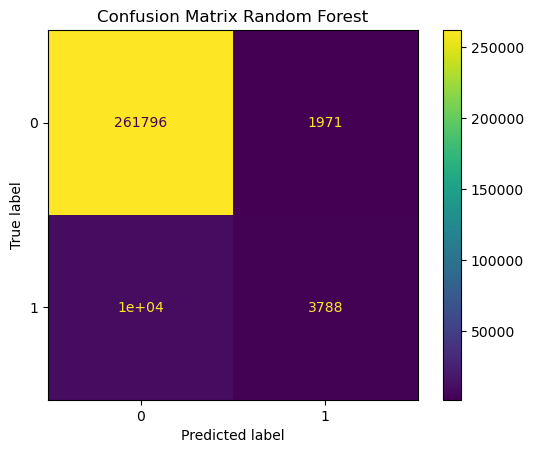

In [38]:
cm = ConfusionMatrixDisplay(np.array([[261796,   1971],
       [10322,  3788]]))
cm.plot()
plt.title('Confusion Matrix Random Forest')
plt.show()

In [13]:
model_SMEs_rf_os_istat_noval

Pipeline(steps=[('model', RandomForestClassifier())])

In [14]:
feature_names_SMEs_rf_istat_noval = [col for col in os_X_train_SMEs_istat.columns]
importances_SMEs_rf_istat_noval = model_SMEs_rf_os_istat_noval['model'].feature_importances_

forest_importances_SMEs_rf_istat_noval = pd.Series(importances_SMEs_rf_istat_noval, index=feature_names_SMEs_rf_istat_noval)

forest_importances_SMEs_rf_istat_noval.sort_values(ascending=False).to_dict()

{'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.039481423107384124,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.03842853763975871,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.026295545366855175,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.026247040431513893,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.020249905221857687,
 'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 2': 0.018204822485149853,
 'Rapporto di indebitamento\nAnno - 1': 0.017871662029842906,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.016591923014528782,
 'Dipendenti\nAnno - 1': 0.01655692333892534,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.012782272299759184,
 'No of companies in corporate group': 0.012664028234533468,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 2': 0.012487434711771954,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 1': 0.010517381338098047,
 'Flusso di cassa di g

In [15]:
accuracy_SMEs_gb_os_istat_noval, cm_SMEs_gb_os_istat_noval, model_SMEs_gb_os_istat_noval = build_and_evaluate_pipeline(
    X_train=os_X_train_SMEs_istat,
    y_train=os_y_train_SMEs_istat,
    X_test=X_test_SMEs_istat_v2,
    y_test=y_test_SMEs_istat_v2,
    model=GradientBoostingClassifier(),
    scaling=False,
    selector_k=None,
    model_param_grid=None,
    scoring='accuracy',
    cv=5
)

In [16]:
accuracy_SMEs_gb_os_istat_noval

0.9408191394034051

In [17]:
cm_SMEs_gb_os_istat_noval

array([[255817,   7950],
       [  8495,   5615]])

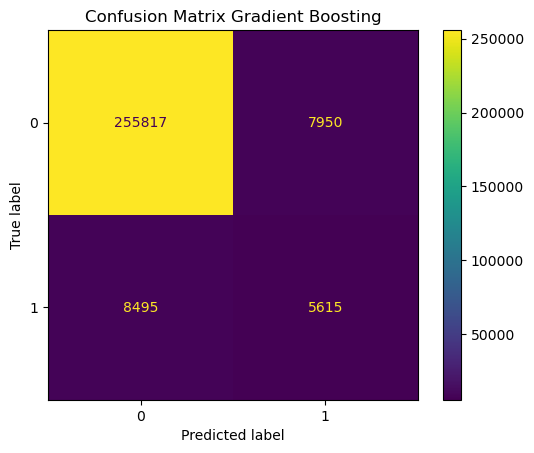

In [40]:
cm = ConfusionMatrixDisplay(np.array([[255817, 7950],
       [8495, 5615]]))
cm.plot()
plt.title('Confusion Matrix Gradient Boosting')
plt.show()

In [18]:
model_SMEs_gb_os_istat_noval

Pipeline(steps=[('model', GradientBoostingClassifier())])

In [19]:
feature_names_SMEs_gb_istat_noval = [col for col in os_X_train_SMEs_istat.columns]
importances_SMEs_gb_istat_noval = model_SMEs_gb_os_istat_noval['model'].feature_importances_

forest_importances_SMEs_gb_istat_noval = pd.Series(importances_SMEs_gb_istat_noval, index=feature_names_SMEs_gb_istat_noval)

forest_importances_SMEs_gb_istat_noval.sort_values(ascending=False).to_dict()

{'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.2751965079806259,
 'No of companies in corporate group': 0.10582041108254604,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.05817949104964798,
 'Dipendenti\nAnno - 1': 0.05075224746340152,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.046657069137876275,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.04633856032473087,
 'Rapporto di indebitamento\nAnno - 1': 0.024970972396448347,
 'ITA_LC_2020_2021_margine operativo lordo (migliaia di euro)': 0.02458616501061576,
 'Capitale sociale (EUR)': 0.02395166846191854,
 '2019_2020_occupati': 0.020018414217897587,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.01901040227087516,
 '2019_2020_margine operativo lordo (migliaia di euro)': 0.01775000108966428,
 '2020_2021_ore lavorate dai dipendenti (migliaia)': 0.01688720219031982,
 'ITA_LC_2020_2021_acquisto di beni e servizi (migliaia di euro)': 0.0167270

In [ ]:
features_importance_gb_SMEs_istat, results_gb_SMEs_istat = run_model(os_X_train_SMEs_istat, os_y_train_SMEs_istat, X_test_SMEs_istat_v2, y_test_SMEs_istat_v2, model=GradientBoostingClassifier())

In [ ]:
features_importance_gb_SMEs_istat

{'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.24298495179509064,
 'No of companies in corporate group': 0.10460847585432889,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.07627427737509088,
 'Dipendenti\nAnno - 1': 0.059361055134223746,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.05080947977713003,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.04455929841496226,
 'Rapporto di indebitamento\nAnno - 1': 0.03519342582791185,
 '2018_2019_investimenti lordi in beni materiali (migliaia di euro)': 0.027375034802222226,
 'Capitale sociale (EUR)': 0.02077480729551178,
 '2020_2021_ore lavorate dai dipendenti (migliaia)': 0.019174407663557207,
 'ITA_LC_2020_2021_margine operativo lordo (migliaia di euro)': 0.018565358542532825,
 '2019_2020_margine operativo lordo (migliaia di euro)': 0.017741845978594233,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.01656816888853189,
 'ITA_LC_2018_2019_acquist

In [ ]:
results_gb_SMEs_istat

{'Accuracy': 0.805267544990615,
 'Confusion Matrix': array([[127849,  30396],
        [  2077,   6435]]),
 'Threshold': 0.21752763780944895,
 'tpr': array([0.00000000e+00, 1.73761946e-04, 3.47523892e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99984822, 0.99987668,
        1.        ]),
 'auc': 0.8592267896692543}

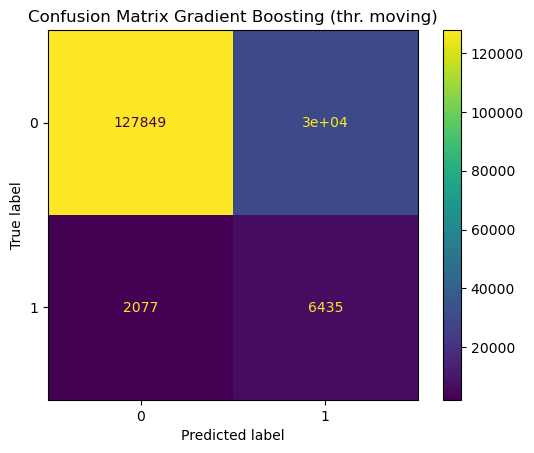

In [20]:
cm = ConfusionMatrixDisplay(np.array(([[127849, 30396],
        [2077, 6435]])))
cm.plot()
plt.title('Confusion Matrix Gradient Boosting (thr. moving)')
plt.show()

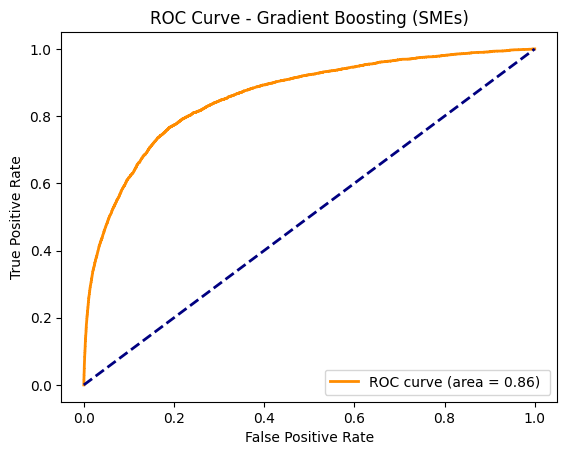

In [ ]:
plot_roc_curve(results_gb_SMEs_istat['fpr'], results_gb_SMEs_istat['tpr'], results_gb_SMEs_istat['auc'], model_name = 'Gradient Boosting (SMEs)')

In [ ]:
features_importance_gb_LargeCompanies_istat, results_gb_LargeCompanies_istat = run_model(os_X_train_LargeCompanies_istat, os_y_train_LargeCompanies_istat, X_test_LargeCompanies_istat_v2, y_test_LargeCompanies_istat_v2, model=GradientBoostingClassifier())

In [ ]:
features_importance_gb_LargeCompanies_istat

{'Oneri finanz. su fatt. (%)\n%\nAnno - 2': 0.3810198218278078,
 'No of companies in corporate group': 0.1350687071541545,
 'Costo denaro a prestito (%)\n%\nAnno - 3': 0.09610920622306371,
 'Operatore estero Encoded': 0.07248560050749112,
 'Debt/EBITDA ratio\n%\nAnno - 1': 0.05622891383375697,
 '2020_2021_investimenti lordi in beni materiali (migliaia di euro)': 0.05418618351420095,
 'Debt/Equity ratio\n%\nAnno - 2': 0.04659183904917163,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 3': 0.030785923573433148,
 'Posizione finanziaria netta\nEUR\n(Rate at last closing date)\nAnno - 4': 0.02372479917939625,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2': 0.017916409760531587,
 'Debiti v/banche su fatt. (%)\n%\nAnno - 2': 0.01475599552084957,
 '2019_2020_acquisto di beni e servizi (migliaia di euro)': 0.011053933762825431,
 'Rotaz. cap. investito (volte)\nAnno - 1': 0.010174813784817697,
 'Posizione finanziaria netta\nEUR\n(Rate at last closing date)\nAnno -

In [ ]:
results_gb_LargeCompanies_istat

{'Accuracy': 0.68125,
 'Confusion Matrix': array([[544, 255],
        [  0,   1]], dtype=int64),
 'Threshold': 0.00033015480354886393,
 'tpr': array([0. , 0. , 0. , 0.5, 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]),
 'fpr': array([0.        , 0.00188679, 0.26603774, 0.26603774, 0.3509434 ,
        0.3509434 , 0.63207547, 0.63584906, 0.65283019, 0.65660377,
        0.75660377, 0.76037736, 0.78679245, 0.79056604, 0.80377358,
        0.80754717, 0.83396226, 0.83773585, 0.93773585, 0.94150943,
        1.        ]),
 'auc': 0.6915094339622642}

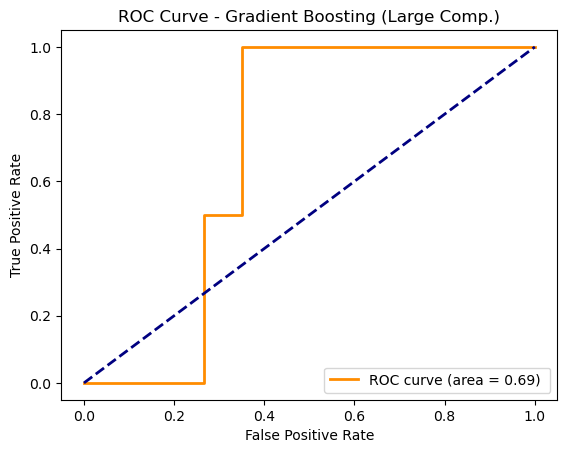

In [ ]:
plot_roc_curve(results_gb_LargeCompanies_istat['fpr'], results_gb_LargeCompanies_istat['tpr'], results_gb_LargeCompanies_istat['auc'], model_name = 'Gradient Boosting (Large Comp.)')

In [ ]:
features_importance_rf_SMEs_istat, results_rf_SMEs_istat = run_model(os_X_train_SMEs_istat, os_y_train_SMEs_istat, X_test_SMEs_istat_v2, y_test_SMEs_istat_v2, model=RandomForestClassifier())

In [ ]:
features_importance_rf_SMEs_istat

{'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 1': 0.03764197573760168,
 'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 1': 0.0369926044103994,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 1': 0.03509457619106411,
 'Patrimonio Netto\nEUR\n(Rate at last closing date)\nAnno - 1': 0.02220767804889726,
 'Rapporto di indebitamento\nAnno - 1': 0.02016908108214801,
 'Redditività del totale attivo (ROA) (%)\n%\nAnno - 1': 0.01954133143272086,
 'Dipendenti\nAnno - 1': 0.017440898358811338,
 'Indice di copertura delle immob. (patrimoniale)\n%\nAnno - 1': 0.015601429451320254,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3': 0.015561201191357758,
 'Rotaz. cap. cir. lordo (volte)\nAnno - 1': 0.013411750237616095,
 'No of companies in corporate group': 0.01306976199852969,
 'EBITDA/Vendite (%)\n%\nAnno - 1': 0.012729874559539943,
 'Margine sui consumi\nEUR\n(Rate at last closing date)\nAnno - 3': 0.012399950343660825,
 'EBITD

In [ ]:
results_rf_SMEs_istat

{'Accuracy': 0.807409717682199,
 'Confusion Matrix': array([[128189,  30105],
        [  2005,   6428]]),
 'Threshold': 0.14,
 'tpr': array([0.00000000e+00, 1.76149375e-04, 3.52298749e-04, 7.04597499e-04,
        2.28994187e-03, 4.22758499e-03, 6.16522811e-03, 7.92672186e-03,
        1.10974106e-02, 1.32112031e-02, 1.56772943e-02, 1.88479831e-02,
        2.11379250e-02, 2.74793024e-02, 3.20591862e-02, 3.75198168e-02,
        4.24519993e-02, 4.80887793e-02, 5.44301568e-02, 5.97146380e-02,
        6.55275674e-02, 7.22212436e-02, 7.85626211e-02, 8.45516998e-02,
        8.93077330e-02, 9.63537079e-02, 1.03399683e-01, 1.10093359e-01,
        1.16082438e-01, 1.24889907e-01, 1.31231284e-01, 1.37924960e-01,
        1.45147085e-01, 1.50783865e-01, 1.57653690e-01, 1.66637308e-01,
        1.73859433e-01, 1.80553109e-01, 1.89184428e-01, 1.97463449e-01,
        2.05918619e-01, 2.11555399e-01, 2.20715166e-01, 2.28994187e-01,
        2.38153955e-01, 2.47842170e-01, 2.54535846e-01, 2.62638718e-01,
   

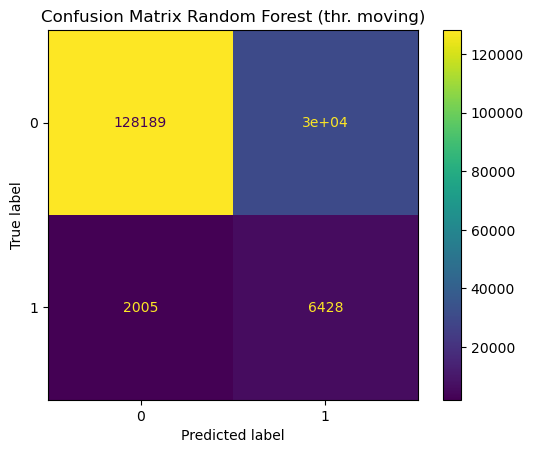

In [21]:
cm = ConfusionMatrixDisplay(np.array([[128189, 30105],
        [2005, 6428]]))
cm.plot()
plt.title('Confusion Matrix Random Forest (thr. moving)')
plt.show()

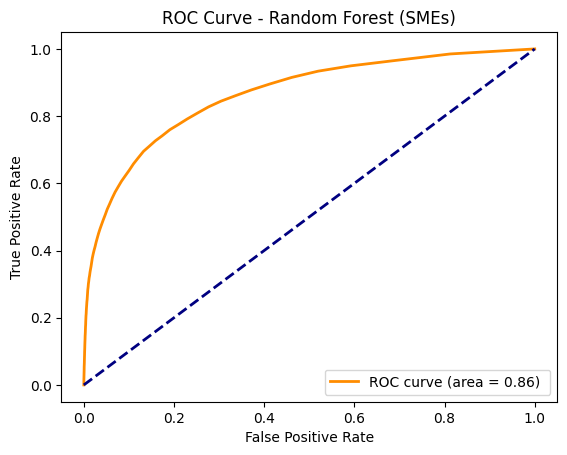

In [ ]:
plot_roc_curve(results_rf_SMEs_istat['fpr'], results_rf_SMEs_istat['tpr'], results_rf_SMEs_istat['auc'], model_name = 'Random Forest (SMEs)')

In [ ]:
features_importance_rf_LargeCompanies_istat, results_rf_LargeCompanies_istat = run_model(os_X_train_LargeCompanies_istat, os_y_train_LargeCompanies_istat, X_test_LargeCompanies_istat_v2, y_test_LargeCompanies_istat_v2, model=RandomForestClassifier())

In [ ]:
features_importance_rf_LargeCompanies_istat

{'Oneri finanz. su fatt. (%)\n%\nAnno - 2': 0.08553119389114348,
 'Debt/Equity ratio\n%\nAnno - 2': 0.06356014886578233,
 'Oneri finanz. su fatt. (%)\n%\nAnno - 1': 0.04648718245533485,
 'Debt/Equity ratio\n%\nAnno - 3': 0.04343126915707831,
 'Posizione finanziaria netta\nEUR\n(Rate at last closing date)\nAnno - 3': 0.04276691714367174,
 'No of companies in corporate group': 0.03844369494102182,
 'Debt/EBITDA ratio\n%\nAnno - 1': 0.038296366440781486,
 'Debt/EBITDA ratio\n%\nAnno - 3': 0.038172631844654595,
 'Debiti v/banche su fatt. (%)\n%\nAnno - 3': 0.036580744999611,
 '2020_2021_investimenti lordi in beni materiali (migliaia di euro)': 0.0286374361412621,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 2': 0.028587564157029805,
 'Debt/EBITDA ratio\n%\nAnno - 2': 0.023578388643872666,
 'Flusso di cassa di gestione\nEUR\n(Rate at last closing date)\nAnno - 3': 0.022927029455153413,
 'EBITDA\nEUR\n(Rate at last closing date)\nAnno - 3': 0.02183958347877995,
 'C

In [ ]:
results_rf_LargeCompanies_istat

{'Accuracy': 0.9975,
 'Confusion Matrix': array([[798,   0],
        [  2,   0]], dtype=int64),
 'Threshold': 1.35,
 'tpr': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 'fpr': array([0.        , 0.00188324, 0.01506591, 0.02071563, 0.03578154,
        0.04143126, 0.05461394, 0.06214689, 0.07909605, 0.10546139,
        0.13559322, 0.19962335, 0.35404896, 1.        ]),
 'auc': 0.32297551789077217}

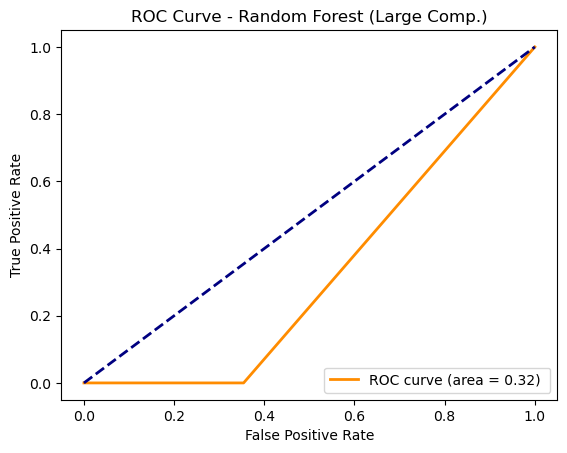

In [ ]:
plot_roc_curve(results_rf_LargeCompanies_istat['fpr'], results_rf_LargeCompanies_istat['tpr'], results_rf_LargeCompanies_istat['auc'], model_name = 'Random Forest (Large Comp.)')